# <div style="color:orange;">[Projet] Prêt à dépenser - Modèle de scoring</div>

<img src="img/pad_logo.png" width="150">

# <div style="color:blue" id="ch0">0. Plan du Notebook</div>

1. [Contexte et description du jeu de données](#ch1)<br><br>
2. [Imports, fonctions générales et analyse exploratoire](#ch2)<br>
>2.1 [Imports et fonctions générales](#ch2_1)<br>
>2.2 [Analyse : Bureau](#ch2_2)<br>
>2.3 [Analyse : Bureau_balance](#ch2_3)<br>
>2.4 [Analyse : Previous_application](#ch2_4)<br>
>2.5 [Analyse : POS_CASH_balance](#ch2_5)<br>
>2.6 [Analyse : Installments_payments](#ch2_6)<br>
>2.7 [Analyse : Credit_card_balance](#ch2_7)<br>
>2.8 [Analyse : Application](#ch2_8)<br>

3. [Feature engineering](#ch3)<br>
>3.1 [Valeurs statistiques](#ch3_1)<br>
>3.2 [Feature engineering automatisé](#ch3_2)<br>
>3.3 [Encodage simple](#ch3_3)<br>

4. [Sélection de la métrique de scoring et du modèle d'apprentissage](#ch4)<br>
>4.0 [Préparation des jeux de données](#ch4_0)<br>
>4.1 [Métrique de scoring](#ch4_1)<br>
>4.2 [LogisticRegression](#ch4_2)<br>
>4.3 [RandomForestClassifier](#ch4_3)<br>
>4.4 [LGBMClassifier](#ch4_4)<br>
>4.5 [XGBClassifier](#ch4_5)<br>
>4.6 [Configuration retenue](#ch4_6)<br>

5. [Conclusion](#ch5)

# <div id="ch1" style="color: blue">1. Contexte et description du jeu de données</div>

<div class="alert alert-block alert-warning">
    <b><u>Objectif</u></b><br>
    
Mettre en œuvre un outil de “scoring crédit” qui calcule la <b>probabilité qu’un client rembourse ou non un crédit à la consommation</b>, puis classifie la demande : crédit accordé ou refusé.<br>

Les chargés de relation client ont besoin que le modèle soit <b>facilement interprétable</b>. Ils souhaitent disposer d’une <b>mesure de l’importance des variables</b> qui ont poussé le modèle à donner cette probabilité à un client.
</div>

<img src="img/schéma_p4.png">

Afin de répondre au mieux au besoin du client nous allons tester plusieurs stratégies de feature analysis et plusieurs modèle, et nous retiendrons la meilleure option de ce tableau :

<img src="img/strategie_table_vide.png">

[*(Retour sommaire)*](#ch0)

# <div id="ch2" style="color: blue">2. Imports, fonctions générales et analyse exploratoire</div>

## <div id="ch2_1" style="color: orange;">2.1 Imports et fonctions générales</div>

In [541]:
import re
import gc
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import featuretools as ft
import joblib
import shap
from featuretools import selection
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_curve
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from lime.lime_tabular import LimeTabularExplainer

pd.set_option('display.max_columns', 122)
pd.set_option('display.max_row', 122)

In [3]:
# Source : https://openclassrooms.com/fr/courses/4525281-realisez-une-analyse-exploratoire-de-donnees/5345201-tp-realisez-une-acp
from matplotlib.collections import LineCollection

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            fig, ax = plt.subplots(figsize=(7,6))
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center',
                                 rotation=label_rotation, color="blue", alpha=0.5)
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, 
                             illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:  
            fig = plt.figure(figsize=(7,6))
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2],
                                alpha=alpha, label=value)
                plt.legend()
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
    
def display_pca(df, split=None, n_comp=6): 
    X = df.values
    features = df.columns
    X_scaled = StandardScaler().fit_transform(X)
    pca = PCA(n_components=n_comp)
    pca.fit(X_scaled)
    display_scree_plot(pca)
    pcs = pca.components_
    display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels=np.array(features))
    #display_circles(pcs, n_comp, pca, [(0,1)], lims=[.0155, .019, 0.053, .057], labels=np.array(features))
    #display_circles(pcs, n_comp, pca, [(2,3)], lims=[-.035, -.026, -.03,-.016], labels=np.array(features))
    X_projected = pca.transform(X_scaled)
    display_factorial_planes(X_projected, n_comp, pca, 
                             [(0,1),(2,3),(4,5)], alpha=0.5, illustrative_var=split)
    plt.show()

In [4]:
def display_distri(df, dataset_name=None, quali=False, bins=None):
    for c in df.columns:
        plt.figure()
        if (quali == False) & (bins != None):
            sns.histplot(data=df[c], bins=bins)
        else:
            sns.histplot(data=df[c])
        if dataset_name == None:
            plt.title(f"Distribution de {c}")
        else:
            plt.title(f"Distribution de {dataset_name}.{c}")
        if (len(df[c].unique()) > 4) & (quali == True):
            plt.xticks(rotation=90)
        plt.show()

In [2]:
app = pd.read_csv('csv/application_train.csv')
bur = pd.read_csv('csv/bureau.csv')
bur_bal = pd.read_csv('csv/bureau_balance.csv')
pos = pd.read_csv('csv/POS_CASH_balance.csv')
cc_bal = pd.read_csv('csv/credit_card_balance.csv')
prev = pd.read_csv('csv/previous_application.csv')
ins = pd.read_csv('csv/installments_payments.csv')

[*(Retour sommaire)*](#ch0)

## <div id="ch2_2" style="color: orange;">2.2 Analyse : Bureau</div>

In [5]:
bur.shape

(1716428, 17)

In [6]:
bur.describe(include='all')

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  \
count   1.716428e+06  1.716428e+06       1716428         1716428   
unique           NaN           NaN             4               4   
top              NaN           NaN        Closed      currency 1   
freq             NaN           NaN       1079273         1715020   
mean    2.782149e+05  5.924434e+06           NaN             NaN   
std     1.029386e+05  5.322657e+05           NaN             NaN   
min     1.000010e+05  5.000000e+06           NaN             NaN   
25%     1.888668e+05  5.463954e+06           NaN             NaN   
50%     2.780550e+05  5.926304e+06           NaN             NaN   
75%     3.674260e+05  6.385681e+06           NaN             NaN   
max     4.562550e+05  6.843457e+06           NaN             NaN   

         DAYS_CREDIT  CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  \
count   1.716428e+06        1.716428e+06         1.610875e+06   
unique           NaN                 NaN                  NaN   
top              NaN                 NaN                  NaN   
freq             NaN                 NaN                  NaN   
mean   -1.142108e+03        8.181666e-01         5.105174e+02   
std     7.951649e+02        3.654443e+01         4.994220e+03   
min    -2.922000e+03        0.000000e+00        -4.206000e+04   
25%    -1.666000e+03        0.000000e+00        -1.138000e+03   
50%    -9.870000e+02        0.000000e+00        -3.300000e+02   
75%    -4.740000e+02        0.000000e+00         4.740000e+02   
max     0.000000e+00        2.792000e+03         3.119900e+04   

        DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  \
count        1.082775e+06            5.919400e+05        1.716428e+06   
unique                NaN                     NaN                 NaN   
top                   NaN                     NaN                 NaN   
freq                  NaN                     NaN                 NaN   
mean        -1.017437e+03            3.825418e+03        6.410406e-03   
std          7.140106e+02            2.060316e+05        9.622391e-02   
min         -4.202300e+04            0.000000e+00        0.000000e+00   
25%         -1.489000e+03            0.000000e+00        0.000000e+00   
50%         -8.970000e+02            0.000000e+00        0.000000e+00   
75%         -4.250000e+02            0.000000e+00        0.000000e+00   
max          0.000000e+00            1.159872e+08        9.000000e+00   

        AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  \
count     1.716415e+06         1.458759e+06          1.124648e+06   
unique             NaN                  NaN                   NaN   
top                NaN                  NaN                   NaN   
freq               NaN                  NaN                   NaN   
mean      3.549946e+05         1.370851e+05          6.229515e+03   
std       1.149811e+06         6.774011e+05          4.503203e+04   
min       0.000000e+00        -4.705600e+06         -5.864061e+05   
25%       5.130000e+04         0.000000e+00          0.000000e+00   
50%       1.255185e+05         0.000000e+00          0.000000e+00   
75%       3.150000e+05         4.015350e+04          0.000000e+00   
max       5.850000e+08         1.701000e+08          4.705600e+06   

        AMT_CREDIT_SUM_OVERDUE      CREDIT_TYPE  DAYS_CREDIT_UPDATE  \
count             1.716428e+06          1716428        1.716428e+06   
unique                     NaN               15                 NaN   
top                        NaN  Consumer credit                 NaN   
freq                       NaN          1251615                 NaN   
mean              3.791276e+01              NaN       -5.937483e+02   
std               5.937650e+03              NaN        7.207473e+02   
min               0.000000e+00              NaN       -4.194700e+04   
25%               0.000000e+00              NaN       -9.080000e+02   
50%               0.000000e+00              NaN       -3.950000e+02

In [7]:
bur.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

<AxesSubplot:>

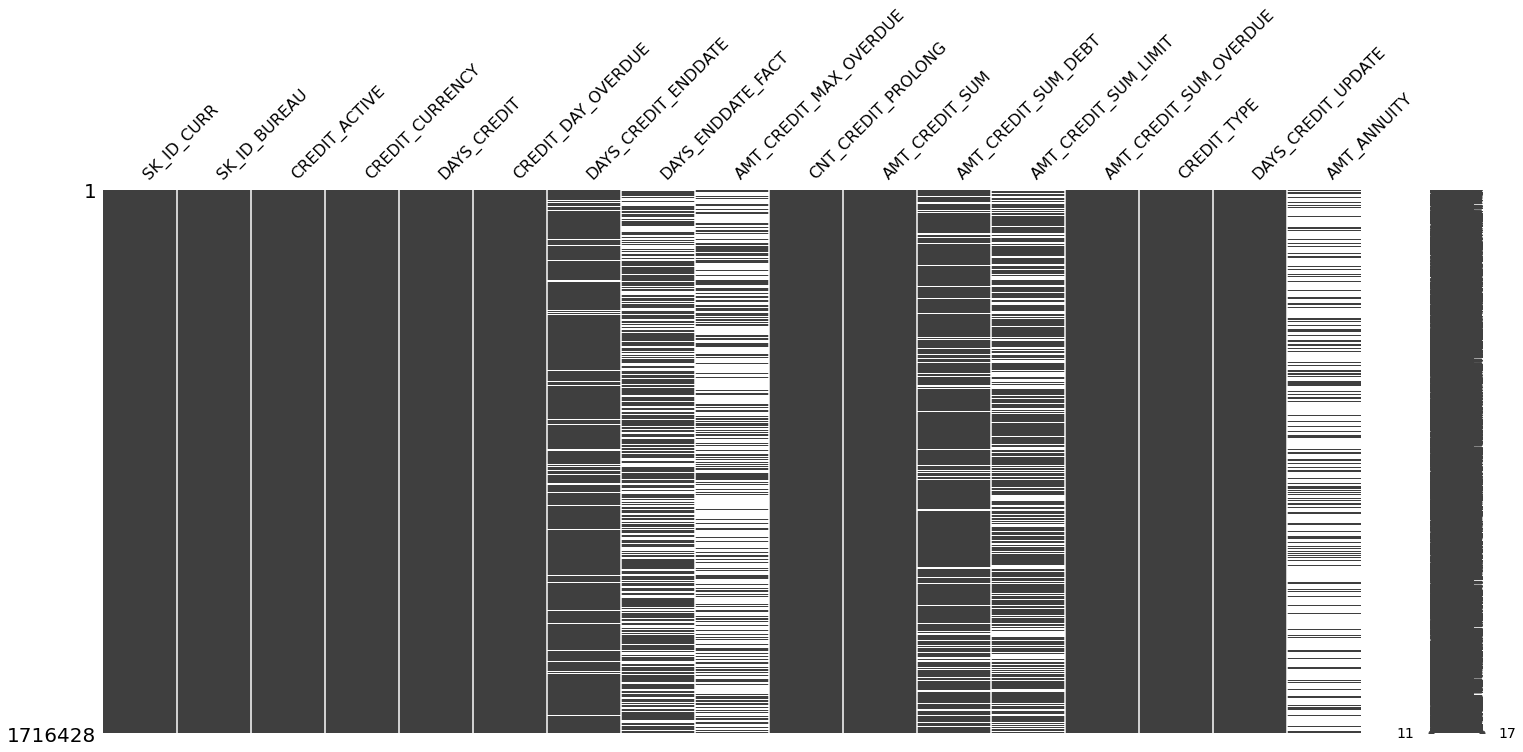

In [8]:
msno.matrix(bur)

In [9]:
(bur.isna().sum()/bur.shape[0]).sort_values(ascending=False)

AMT_ANNUITY               0.714735
AMT_CREDIT_MAX_OVERDUE    0.655133
DAYS_ENDDATE_FACT         0.369170
AMT_CREDIT_SUM_LIMIT      0.344774
AMT_CREDIT_SUM_DEBT       0.150119
DAYS_CREDIT_ENDDATE       0.061496
AMT_CREDIT_SUM            0.000008
CREDIT_ACTIVE             0.000000
CREDIT_CURRENCY           0.000000
DAYS_CREDIT               0.000000
CREDIT_DAY_OVERDUE        0.000000
SK_ID_BUREAU              0.000000
CNT_CREDIT_PROLONG        0.000000
AMT_CREDIT_SUM_OVERDUE    0.000000
CREDIT_TYPE               0.000000
DAYS_CREDIT_UPDATE        0.000000
SK_ID_CURR                0.000000
dtype: float64

In [21]:
bur_quali = bur.select_dtypes(exclude=np.number)
bur_quanti = bur.select_dtypes(include=np.number)
bur_quanti = bur_quanti.drop(['SK_ID_CURR', 'SK_ID_BUREAU'], axis=1)

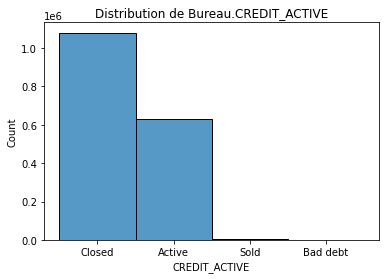

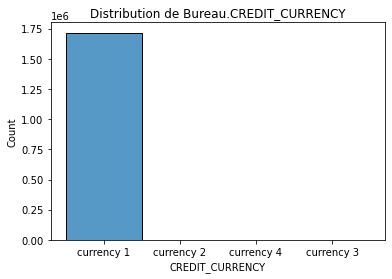

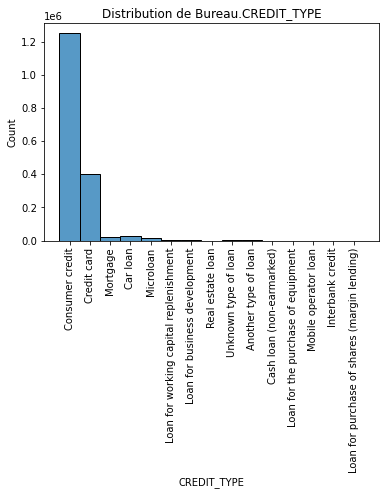

In [11]:
display_distri(bur_quali, dataset_name='Bureau', quali=True)

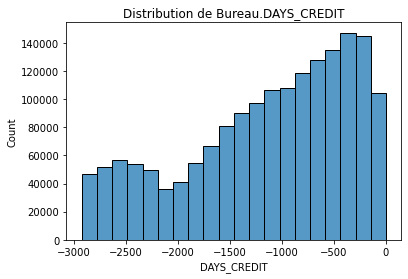

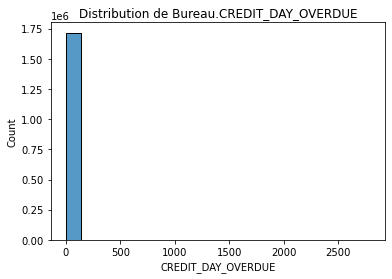

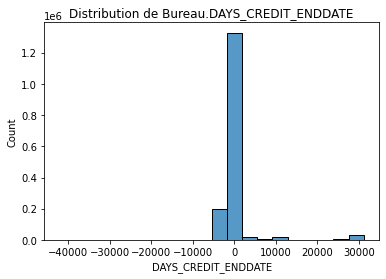

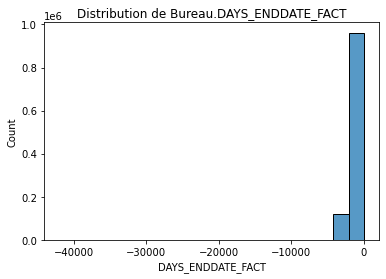

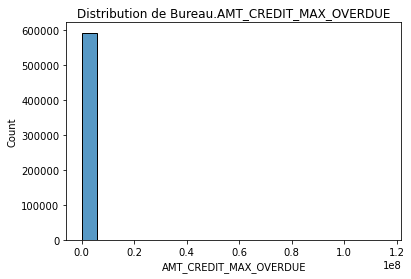

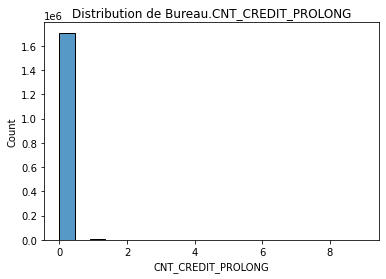

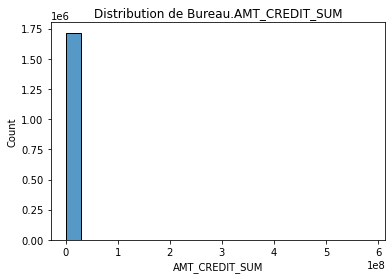

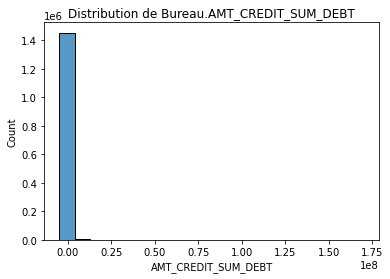

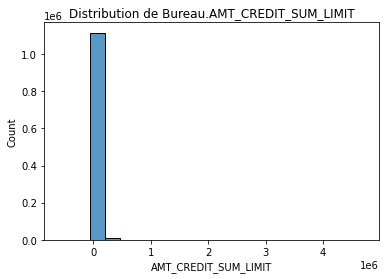

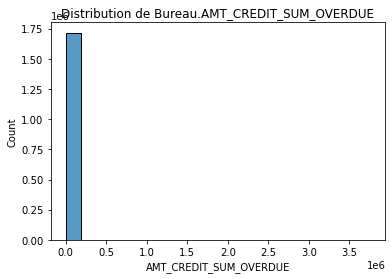

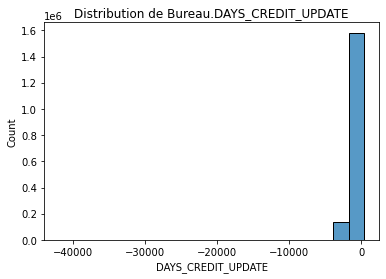

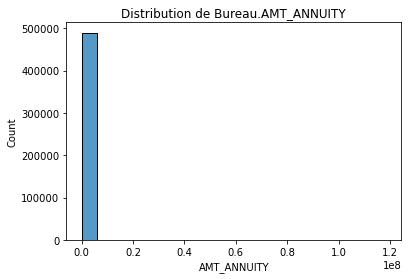

In [12]:
display_distri(bur_quanti, dataset_name='Bureau', bins=20)

<AxesSubplot:>

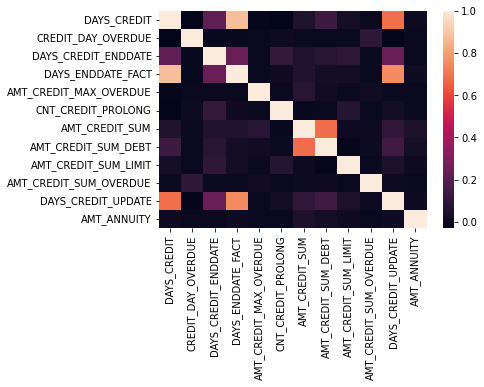

In [13]:
sns.heatmap(bur_quanti.corr())

In [23]:
simple = SimpleImputer(strategy='median')
bur_quanti_filled = pd.DataFrame(simple.fit_transform(bur_quanti), columns=bur_quanti.columns)
bur_quanti_filled.isna().sum().sum()

0

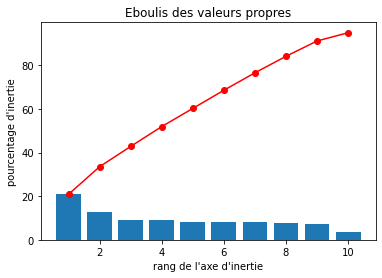

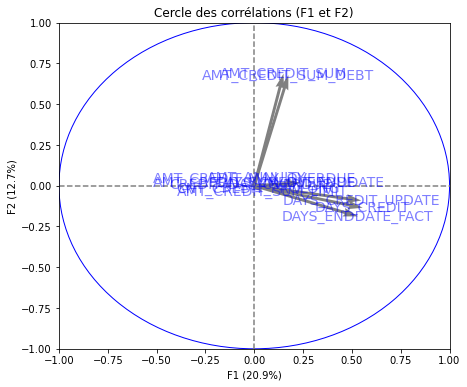

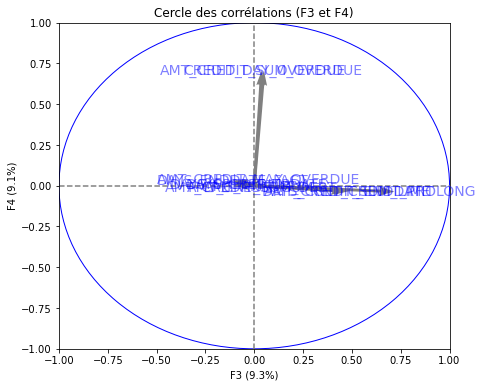

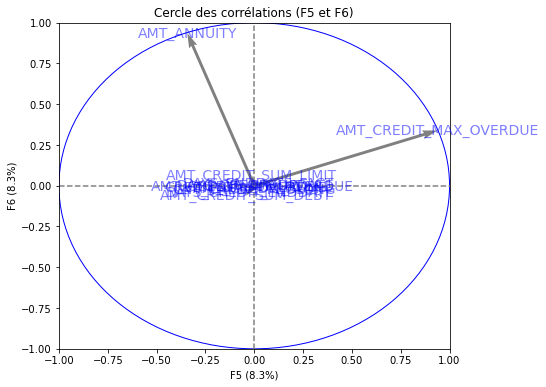

C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


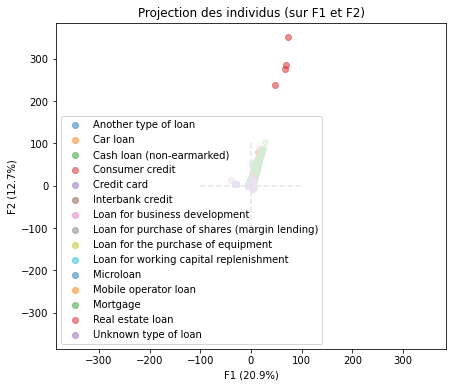

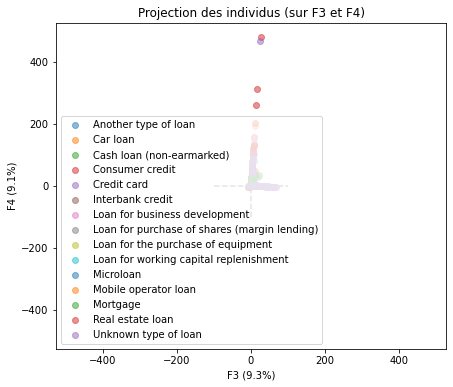

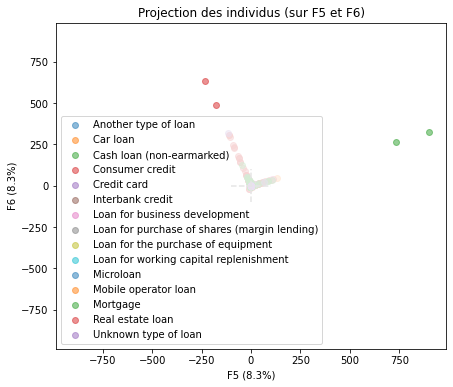

In [31]:
display_pca(bur_quanti_filled, split=bur[['CREDIT_TYPE']], n_comp=10)

<div class="alert alert-block alert-info">
    <b><u>Analyse</u> : Bureau</b><br>
    
<b>Variables qualitatives</b>
     
La majorité des crédits accordés sont des crédits à la consommation et de carte de crédit. La plupart des crédits sont en statut Active ou Cloturé, les crédits revendus ou perdus sont très minoritaires. La devise ne jouera aucun rôle, car presque tous les prêts ont été accordé dans la même devise (Currency 1).<br><br>
    
<b>Variables quantitatives</b>
    
Les distributions individuelles suggèrent peu de retards de paiements et de demande de prolongation de crédit. Ceci est corroboré par la distribution de l'ancienneté des crédit (`DAYS_CREDIT`), montrant une décroissance du nombre de crédits détenus à mesure que l'on s'éloigne dans le temps.<br><br>
    
<b>Corrélations linéraires</b>
    
On relève une corrélation entre `DAYS_CREDIT`, `DAYS_ENDDATE_FACT` et `DAYS_CREDIT_UPDATE`, ce qui semble logique, car la mise à jour d'un crédit signifie souvent une modification de sa date de fin, et donc également son nombre de jours. Cette corrélation est également visible dans l'ACP. Cette dernière nous permet en outre de remarquer une corrélation entre `AMT_CREDIT_SUM` et `AMT_CREDIT_DEBT` d'une part, et entre `AMT_CREDIT_OVERDUE` et `DAYS_OVERDUE` d'autre part, ce qui est également conforme à l'intuition que l'on peut avoir de ces variables.
    
    
</div>

Ressource expliquant le rachat de prêts (*credit selling*) : [lennarmortgage.com](https://www.lennarmortgage.com/blog/What-Does-it-Mean-When-Your-Mortgage-is-Sold)<br>
Ressource expliquant la mauvaise dette (*bad debt*) : [investopedia.com](https://www.investopedia.com/terms/b/baddebt.asp)

[*(Retour sommaire)*](#ch0)

## <div id="ch2_3" style="color: orange;">2.3 Analyse : Bureau_balance</div>

In [34]:
bur_bal.shape

(27299925, 3)

In [35]:
bur_bal.describe(include='all')

SK_ID_BUREAU  MONTHS_BALANCE    STATUS
count   2.729992e+07    2.729992e+07  27299925
unique           NaN             NaN         8
top              NaN             NaN         C
freq             NaN             NaN  13646993
mean    6.036297e+06   -3.074169e+01       NaN
std     4.923489e+05    2.386451e+01       NaN
min     5.001709e+06   -9.600000e+01       NaN
25%     5.730933e+06   -4.600000e+01       NaN
50%     6.070821e+06   -2.500000e+01       NaN
75%     6.431951e+06   -1.100000e+01       NaN
max     6.842888e+06    0.000000e+00       NaN

In [36]:
bur_bal.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

<AxesSubplot:>

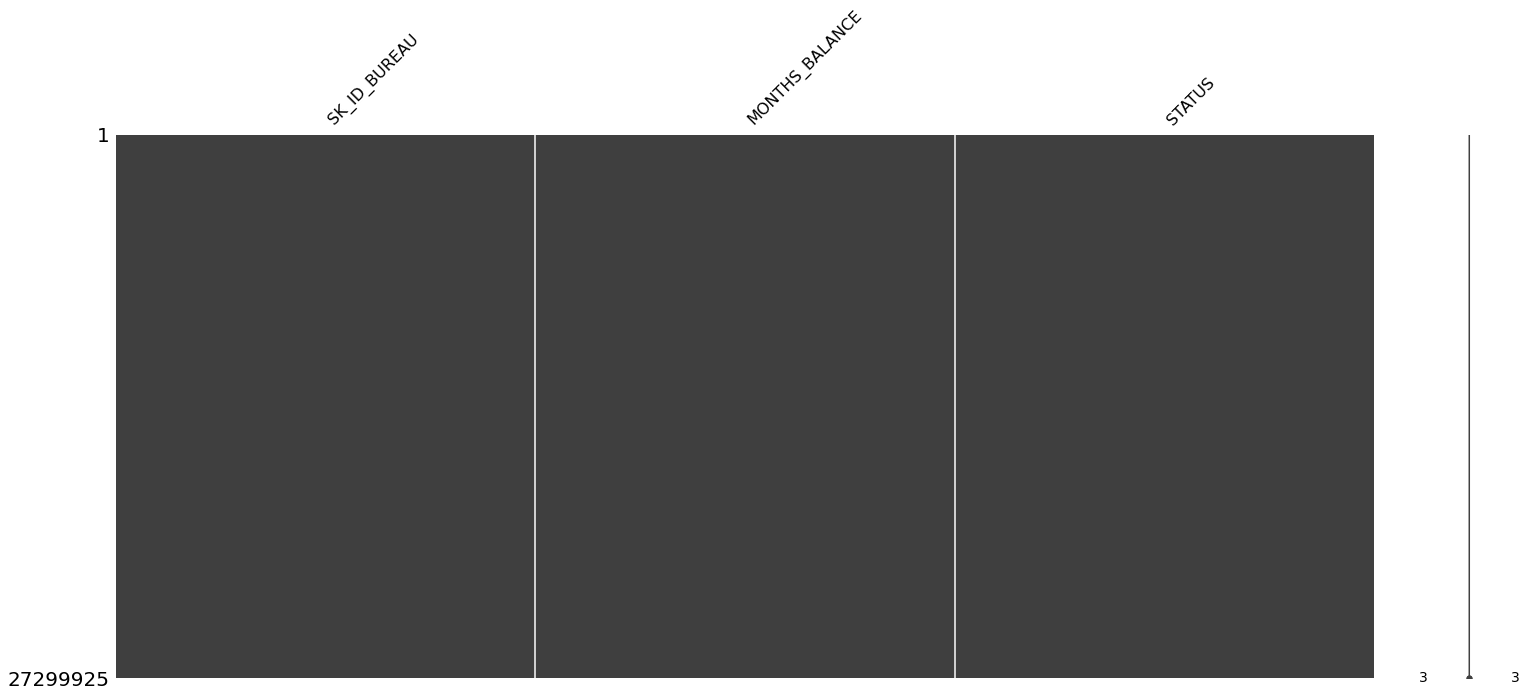

In [37]:
msno.matrix(bur_bal)

In [38]:
(bur_bal.isna().sum()/bur_bal.shape[0]).sort_values(ascending=False)

SK_ID_BUREAU      0.0
MONTHS_BALANCE    0.0
STATUS            0.0
dtype: float64

In [40]:
bur_bal_quali = bur_bal.select_dtypes(exclude=np.number)
bur_bal_quanti = bur_bal.select_dtypes(include=np.number)
bur_bal_quanti = bur_bal_quanti.drop(['SK_ID_BUREAU'], axis=1)

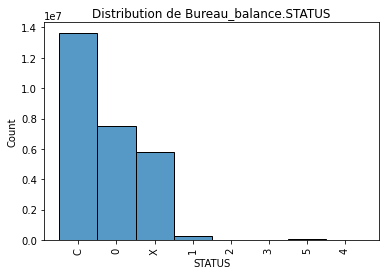

In [41]:
display_distri(bur_bal_quali, dataset_name='Bureau_balance', quali=True)

- C : Closed
- X : Unknown

DPD (Days Past Due) :
- 0 : no DPD
- 1 : 1-30 days
- 2 : 31-60 days, etc.
- 5 : 120+ days | sold | written off

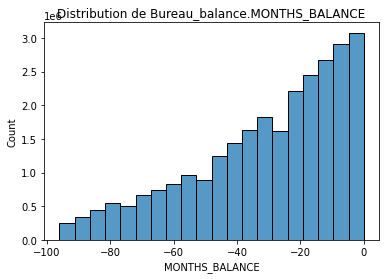

In [42]:
display_distri(bur_bal_quanti, dataset_name='Bureau_balance', bins=20)

<div class="alert alert-block alert-info">
    <b><u>Analyse</u> : Bureau_Balance</b><br>
    
La variable `STATUS` est ici un problème, car ce que la variable représente est fonction de sa valeur. D'un côté elle peut représenter une source d'information très intéressante, de l'autre sa fiabilité est questionnable.<br><br>
    
    
</div>

[*(Retour sommaire)*](#ch0)

## <div id="ch2_4" style="color: orange;">2.4 Analyse : Previous_application</div>

In [44]:
prev.shape

(1670214, 37)

In [45]:
prev.describe(include='all')

SK_ID_PREV    SK_ID_CURR NAME_CONTRACT_TYPE   AMT_ANNUITY  \
count   1.670214e+06  1.670214e+06            1670214  1.297979e+06   
unique           NaN           NaN                  4           NaN   
top              NaN           NaN         Cash loans           NaN   
freq             NaN           NaN             747553           NaN   
mean    1.923089e+06  2.783572e+05                NaN  1.595512e+04   
std     5.325980e+05  1.028148e+05                NaN  1.478214e+04   
min     1.000001e+06  1.000010e+05                NaN  0.000000e+00   
25%     1.461857e+06  1.893290e+05                NaN  6.321780e+03   
50%     1.923110e+06  2.787145e+05                NaN  1.125000e+04   
75%     2.384280e+06  3.675140e+05                NaN  2.065842e+04   
max     2.845382e+06  4.562550e+05                NaN  4.180581e+05   

        AMT_APPLICATION    AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
count      1.670214e+06  1.670213e+06      7.743700e+05     1.284699e+06   
unique              NaN           NaN               NaN              NaN   
top                 NaN           NaN               NaN              NaN   
freq                NaN           NaN               NaN              NaN   
mean       1.752339e+05  1.961140e+05      6.697402e+03     2.278473e+05   
std        2.927798e+05  3.185746e+05      2.092150e+04     3.153966e+05   
min        0.000000e+00  0.000000e+00     -9.000000e-01     0.000000e+00   
25%        1.872000e+04  2.416050e+04      0.000000e+00     5.084100e+04   
50%        7.104600e+04  8.054100e+04      1.638000e+03     1.123200e+05   
75%        1.803600e+05  2.164185e+05      7.740000e+03     2.340000e+05   
max        6.905160e+06  6.905160e+06      3.060045e+06     6.905160e+06   

       WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
count                     1670214             1.670214e+06   
unique                          7                      NaN   
top                       TUESDAY                      NaN   
freq                       255118                      NaN   
mean                          NaN             1.248418e+01   
std                           NaN             3.334028e+00   
min                           NaN             0.000000e+00   
25%                           NaN             1.000000e+01   
50%                           NaN             1.200000e+01   
75%                           NaN             1.500000e+01   
max                           NaN             2.300000e+01   

       FLAG_LAST_APPL_PER_CONTRACT  NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  \
count                      1670214            1.670214e+06      774370.000000   
unique                           2                     NaN                NaN   
top                              Y                     NaN                NaN   
freq                       1661739                     NaN                NaN   
mean                           NaN            9.964675e-01           0.079637   
std                            NaN            5.932963e-02           0.107823   
min                            NaN            0.000000e+00          -0.000015   
25%                            NaN            1.000000e+00           0.000000   
50%                            NaN            1.000000e+00           0.051605   
75%                            NaN            1.000000e+00           0.108909   
max                            NaN            1.000000e+00           1.000000   

        RATE_INTEREST_PRIMARY  RATE_INTEREST_PRIVILEGED  \
count             5951.000000               5951.000000   
unique                    NaN                       NaN   
top                       NaN                       NaN   
freq                      NaN                       NaN   
mean                 0.188357                  0.773503   
std                  0.087671                  0.100879   
min                  0.034781                  0.373150   
25%                  0.160716                  0.71564

In [46]:
prev.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

<AxesSubplot:>

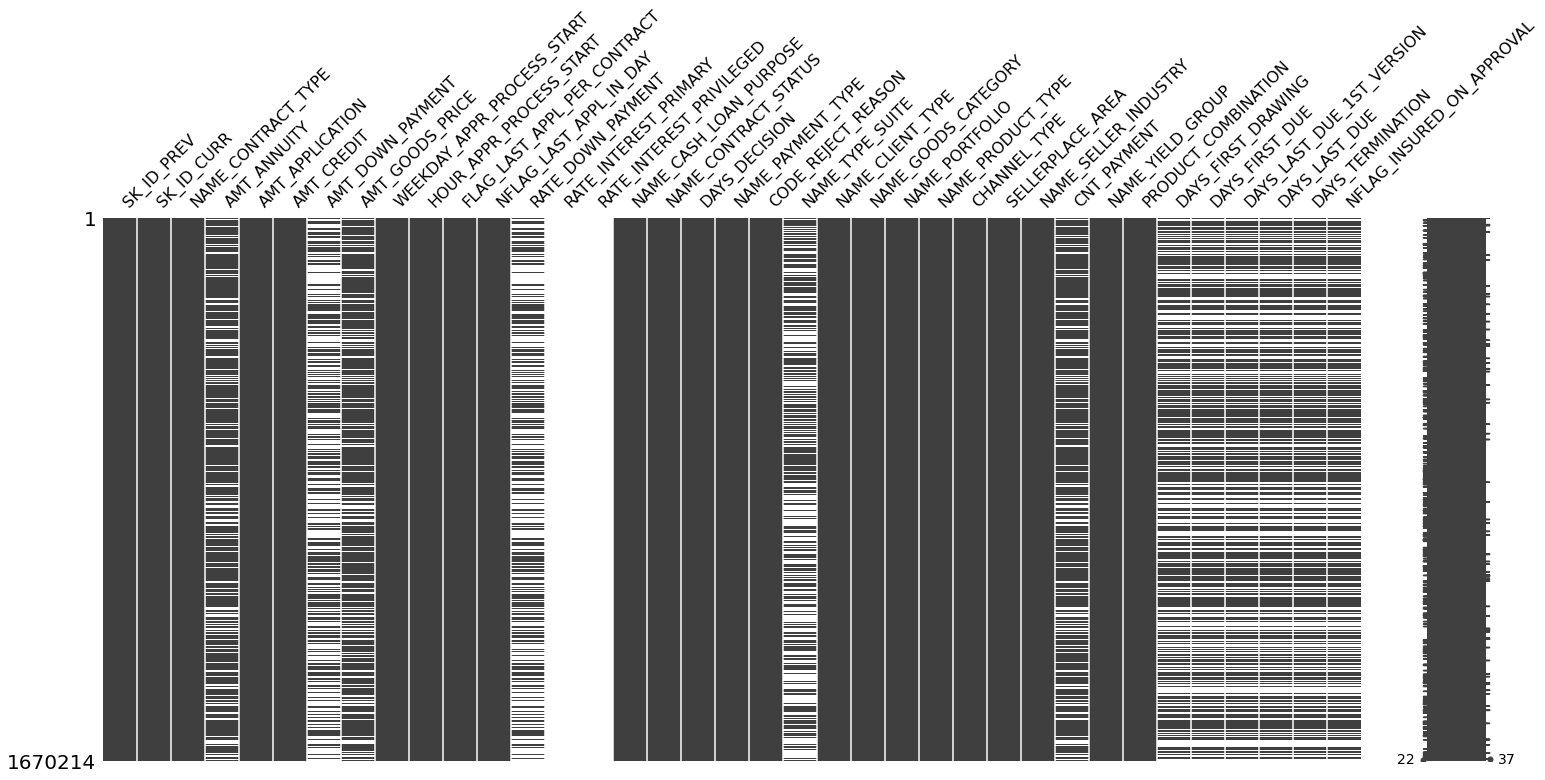

In [47]:
msno.matrix(prev)

In [48]:
(prev.isna().sum()/prev.shape[0]).sort_values(ascending=False)

RATE_INTEREST_PRIVILEGED       9.964370e-01
RATE_INTEREST_PRIMARY          9.964370e-01
AMT_DOWN_PAYMENT               5.363648e-01
RATE_DOWN_PAYMENT              5.363648e-01
NAME_TYPE_SUITE                4.911975e-01
NFLAG_INSURED_ON_APPROVAL      4.029813e-01
DAYS_TERMINATION               4.029813e-01
DAYS_LAST_DUE                  4.029813e-01
DAYS_LAST_DUE_1ST_VERSION      4.029813e-01
DAYS_FIRST_DUE                 4.029813e-01
DAYS_FIRST_DRAWING             4.029813e-01
AMT_GOODS_PRICE                2.308177e-01
AMT_ANNUITY                    2.228667e-01
CNT_PAYMENT                    2.228637e-01
PRODUCT_COMBINATION            2.071591e-04
AMT_CREDIT                     5.987257e-07
NAME_YIELD_GROUP               0.000000e+00
NAME_PORTFOLIO                 0.000000e+00
NAME_SELLER_INDUSTRY           0.000000e+00
SELLERPLACE_AREA               0.000000e+00
CHANNEL_TYPE                   0.000000e+00
NAME_PRODUCT_TYPE              0.000000e+00
SK_ID_PREV                     0

In [49]:
prev_quali = prev.select_dtypes(exclude=np.number)
prev_quanti = prev.select_dtypes(include=np.number)
prev_quanti = prev_quanti.drop(['SK_ID_CURR', 'SK_ID_PREV'], axis=1)

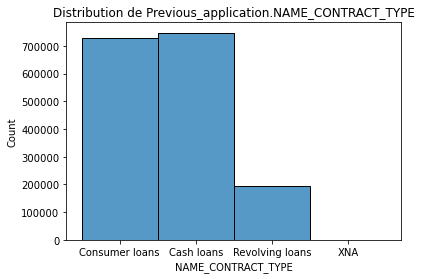

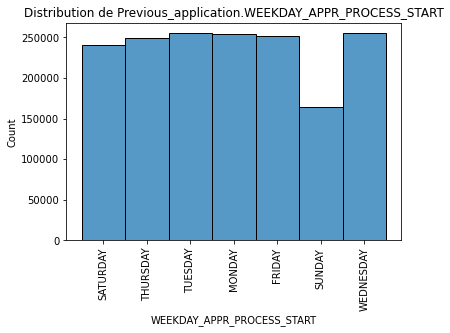

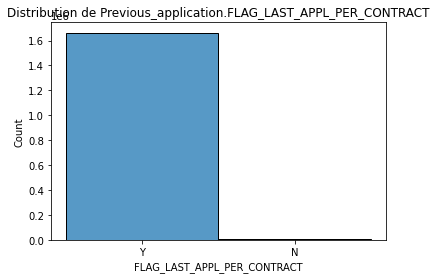

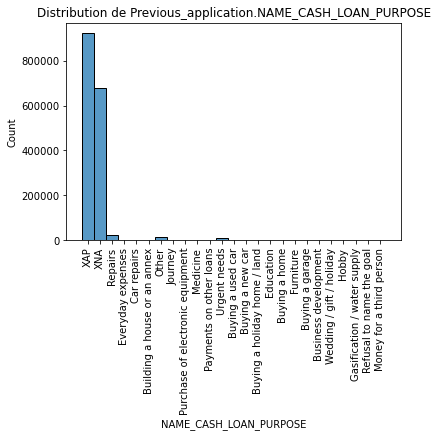

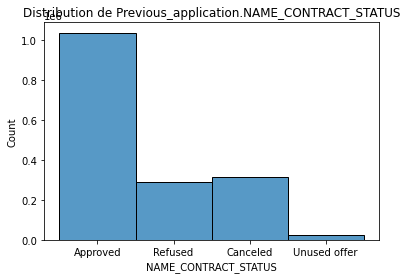

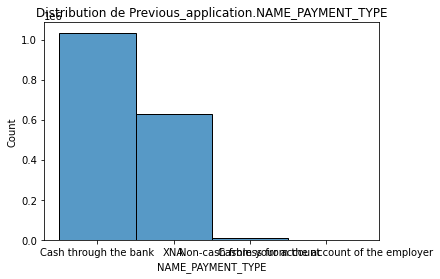

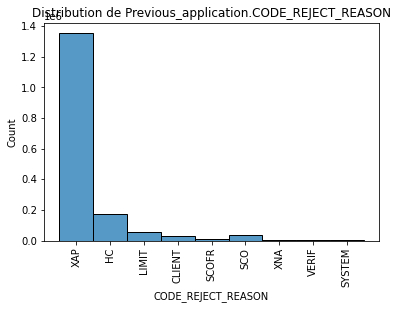

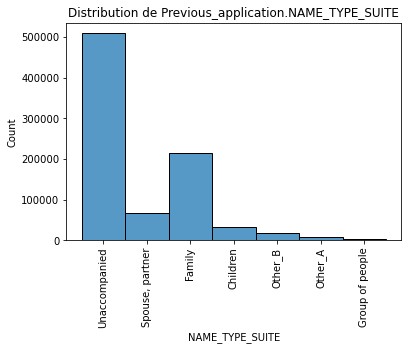

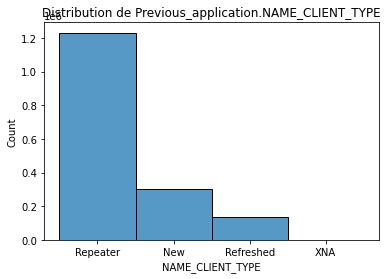

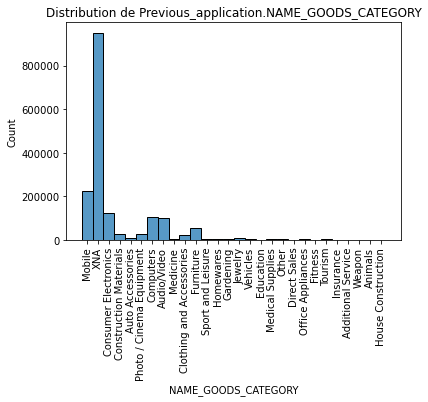

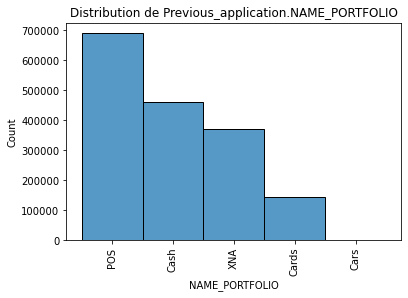

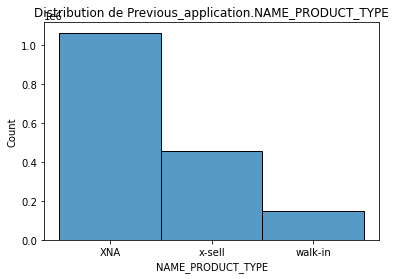

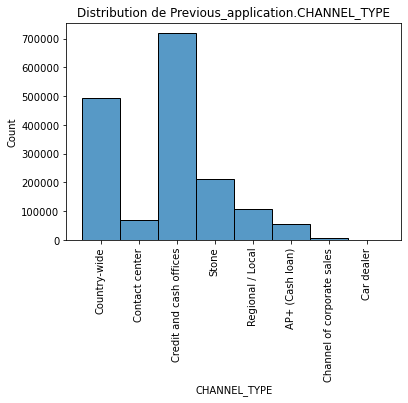

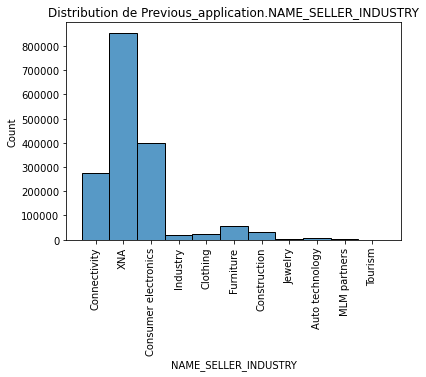

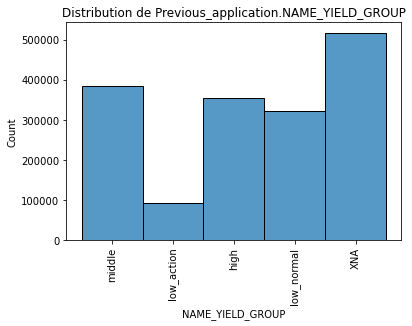

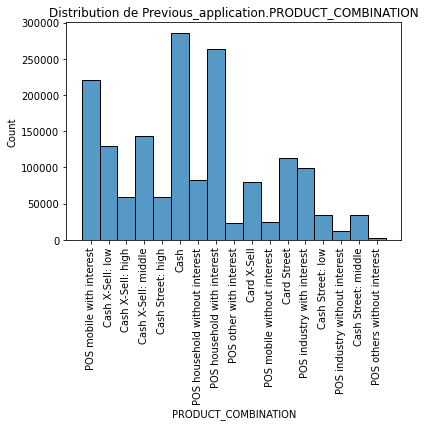

In [50]:
display_distri(prev_quali, dataset_name='Previous_application', quali=True)

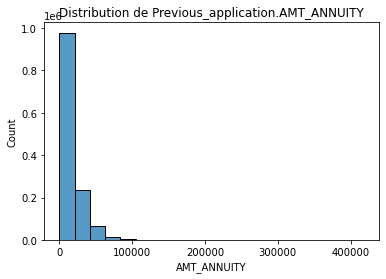

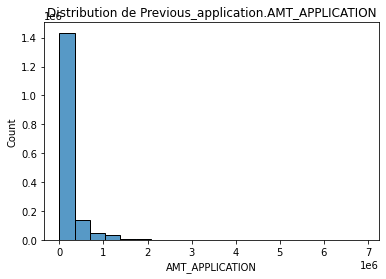

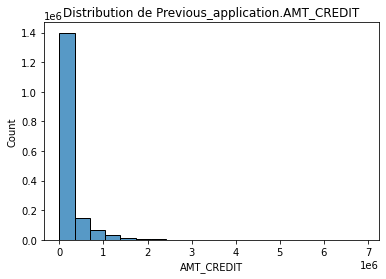

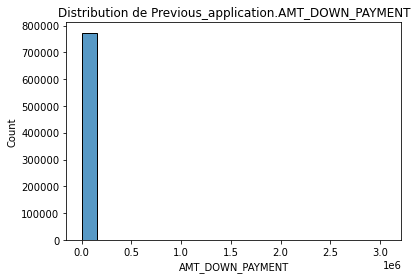

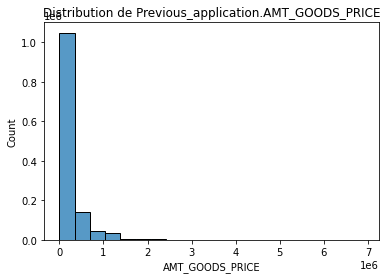

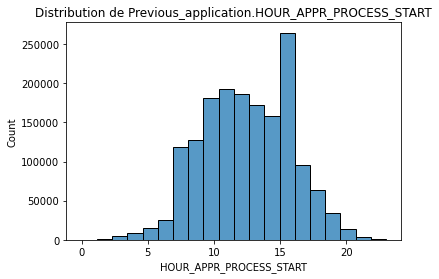

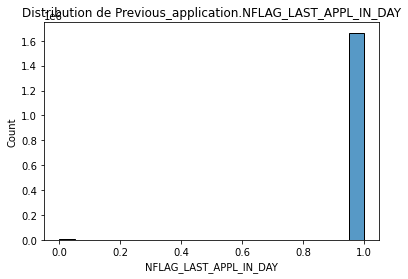

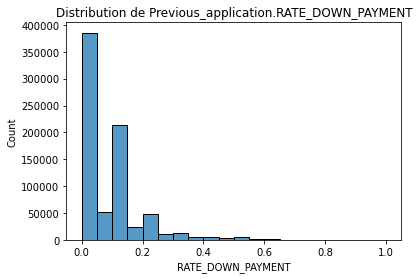

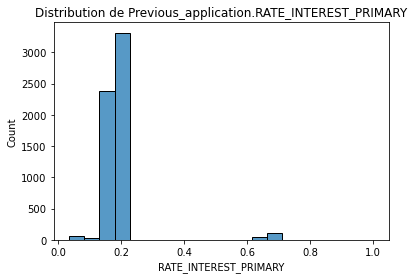

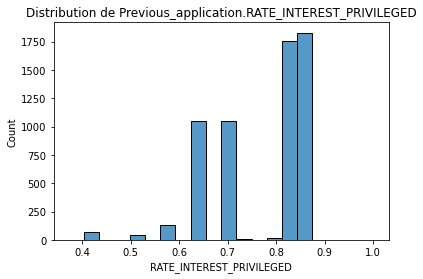

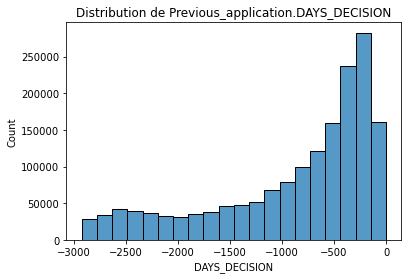

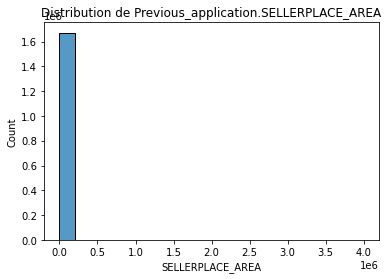

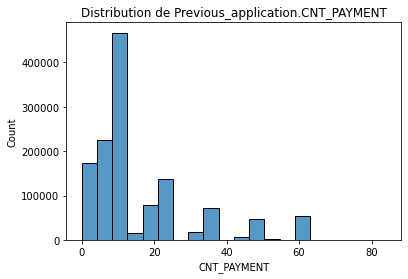

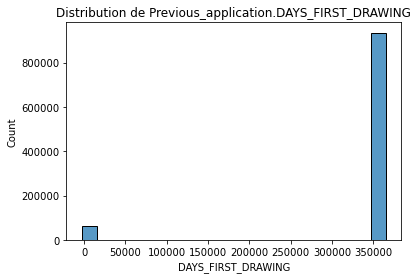

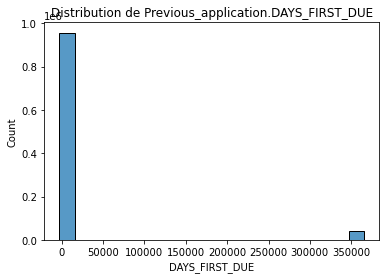

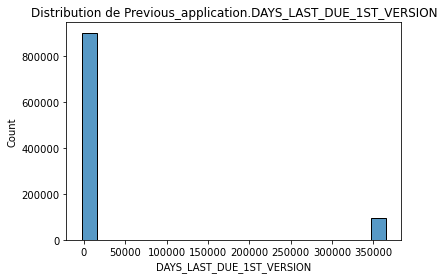

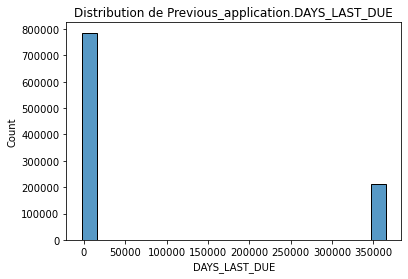

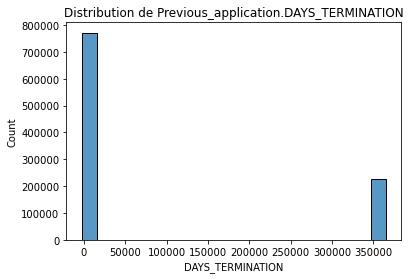

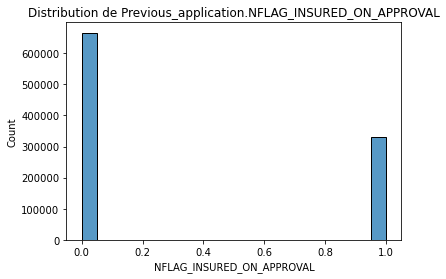

In [51]:
display_distri(prev_quanti, dataset_name='Previous_application', bins=20)

<AxesSubplot:>

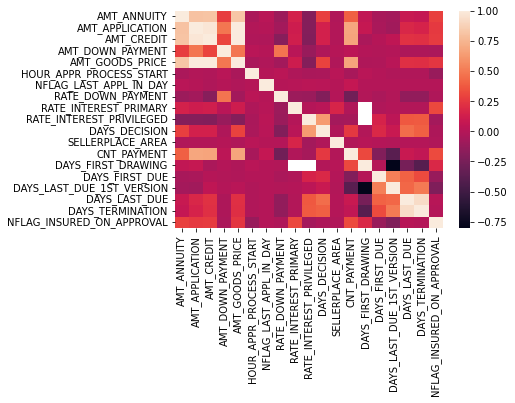

In [52]:
sns.heatmap(prev_quanti.corr())

In [53]:
simple = SimpleImputer(strategy='median')
prev_quanti_filled = pd.DataFrame(simple.fit_transform(prev_quanti), columns=prev_quanti.columns)
prev_quanti_filled.isna().sum().sum()

0

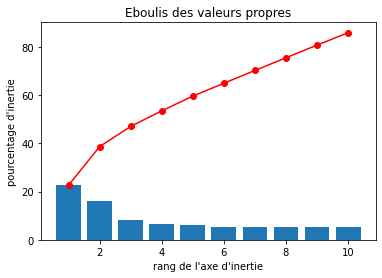

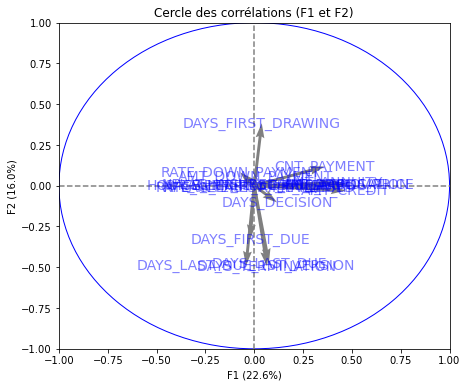

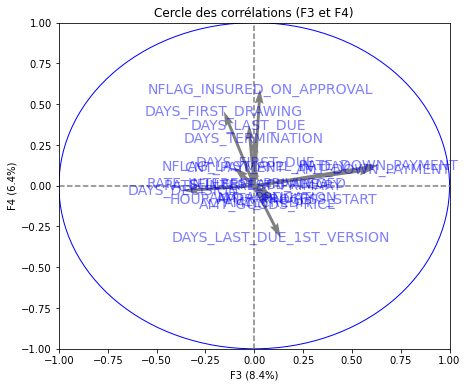

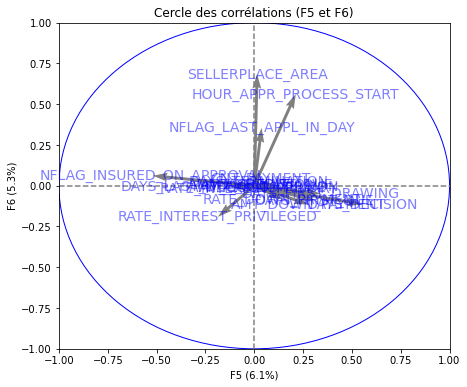

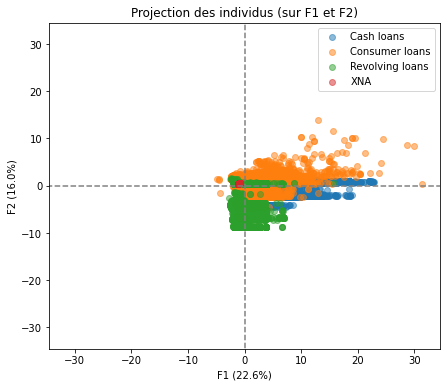

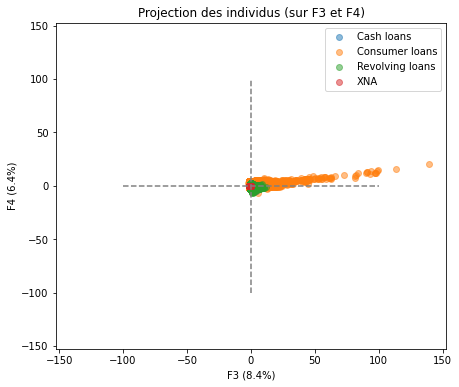

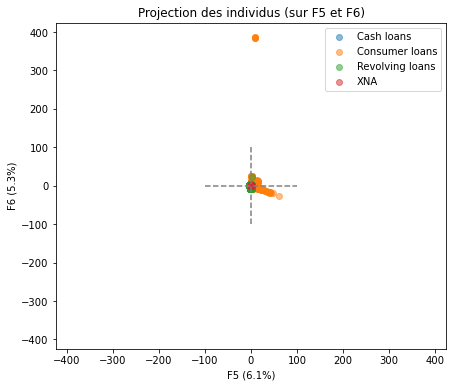

In [55]:
display_pca(prev_quanti_filled, split=prev[['NAME_CONTRACT_TYPE']], n_comp=10)

<div class="alert alert-block alert-info">
    <b><u>Analyse</u> : Previous_Application</b><br>
    
<b>Variables qualitatives</b>
     
La majorité des crédits accordés sont des crédits à la consommation et en cash. L'information relative au jour de souscription ne nous sert foncièrement à rien (information inutile + équirépartition). Le manque de sérieux lors du remplissage des contrat nous empêche d'accéder à une information qui aurait pu se révéler utile : `NAME_CASH_LOAN_PURPOSE` servant en principe à recenser les motifs de souscription, ici remplie majoritairement avec des mentions génériques (XNA, XAP) C'est d'ailleurs le cas pour d'autres variables(`CASH_REJECT_REASON` ou `NAME_PAYMENT_TYPE` par exemple). A l'inverse, `NAME_CONTRACT_STATUS` paraît être une viariable prometteuse, car elle décrit la dernière décision relative au prêt : malgré une majorité d'acceptation, on note une part significative d'annulations et de refus, ainsi qu'une petite part de prêts inutilisés. Très intéressant, le `NAME_CLIENT_TYPE` indique que la proportion de nouveaux clients est faible parmis ceux demandant une souscription : nous pourrons nous intéresser à la proportion de nouveaux clients remboursant leur prêt par rapport à celle des anciens clients.<br><br>
    
<b>Variables quantitatives</b>
    
`AMT_CREDIT` est une variable capitale, car elle va pouvoir nous aider à arbitrer le choix du modèle final sur la base du coût métier entre un faux positif (prêt non accordé à une personne qui l'aurait remboursé) et un faux négatif (prêt accordé à une personne qui ne le remboursera pas). Certaines variables ne nous apportent aucune information utile, à l'instar de `HOUR_APPR_PROCESS_START` (à moins qu'il y ait une "heure des fraudeurs"). Les informations relatives au taux d'intérêt (`RATE_INTEREST_PRIMARY` et `RATE_INTEREST_PRIVILEDGED`) sont à surveiller sur leur impact sur la prédiction finale, car intuitivement on comprend qu'un taux d'intérêt plsu élevé peut entraîner de plus grandes difficultés à rembourser l'emprunt. Enfin, il semble y avoir des valeurs aberrantes dans les variables `DAYS_LAST_DUE`, `DAYS_TERMINATION`, etc. car le nombre de lignes fixées à la valeur "350 000" semble anormalement élevé au regard de la distribution, et cette valeur elle-même est beaucoup trop élevée.<br><br>
    
<b>Corrélations linéraires</b>
    
Deux ensembles de corrélations sont à relever ici. La première concerne les variables `AMT_`, qui rassemble des données relatives au montant du crédit (montant contractualisé, montant révisé effectif, etc.) : on remarque une corrélation très importante, qui laisse à penser qu'une réduction de dimension est envisageable entre elles. De même, `DAYS_LAST_DUE` et `DAYS_TERMINATION` sont très proches sémantiquement et en termes de corrélation. L'ACP de son côté nous suggère une corrélation de `DAYS_FIRST_DUE` et ces deux variables, ainsi qu'une corrélation entre `AMT_DOWN_PAYMENT` et `RATE_DOWN_PAYMENT` qui n'est pas forcément intuitive au premier abord.
    
    
</div>

[*(Retour sommaire)*](#ch0)

## <div id="ch2_5" style="color: orange;">2.5 Analyse : POS_CASH_balance</div>

In [57]:
pos.shape

(10001358, 8)

In [58]:
pos.describe(include='all')

SK_ID_PREV    SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
count   1.000136e+07  1.000136e+07    1.000136e+07    9.975287e+06   
unique           NaN           NaN             NaN             NaN   
top              NaN           NaN             NaN             NaN   
freq             NaN           NaN             NaN             NaN   
mean    1.903217e+06  2.784039e+05   -3.501259e+01    1.708965e+01   
std     5.358465e+05  1.027637e+05    2.606657e+01    1.199506e+01   
min     1.000001e+06  1.000010e+05   -9.600000e+01    1.000000e+00   
25%     1.434405e+06  1.895500e+05   -5.400000e+01    1.000000e+01   
50%     1.896565e+06  2.786540e+05   -2.800000e+01    1.200000e+01   
75%     2.368963e+06  3.674290e+05   -1.300000e+01    2.400000e+01   
max     2.843499e+06  4.562550e+05   -1.000000e+00    9.200000e+01   

        CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS        SK_DPD    SK_DPD_DEF  
count            9.975271e+06             10001358  1.000136e+07  1.000136e+07  
unique                    NaN                    9           NaN           NaN  
top                       NaN               Active           NaN           NaN  
freq                      NaN              9151119           NaN           NaN  
mean             1.048384e+01                  NaN  1.160693e+01  6.544684e-01  
std              1.110906e+01                  NaN  1.327140e+02  3.276249e+01  
min              0.000000e+00                  NaN  0.000000e+00  0.000000e+00  
25%              3.000000e+00                  NaN  0.000000e+00  0.000000e+00  
50%              7.000000e+00                  NaN  0.000000e+00  0.000000e+00  
75%              1.400000e+01                  NaN  0.000000e+00  0.000000e+00  
max              8.500000e+01                  NaN  4.231000e+03  3.595000e+03

In [59]:
pos.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

<AxesSubplot:>

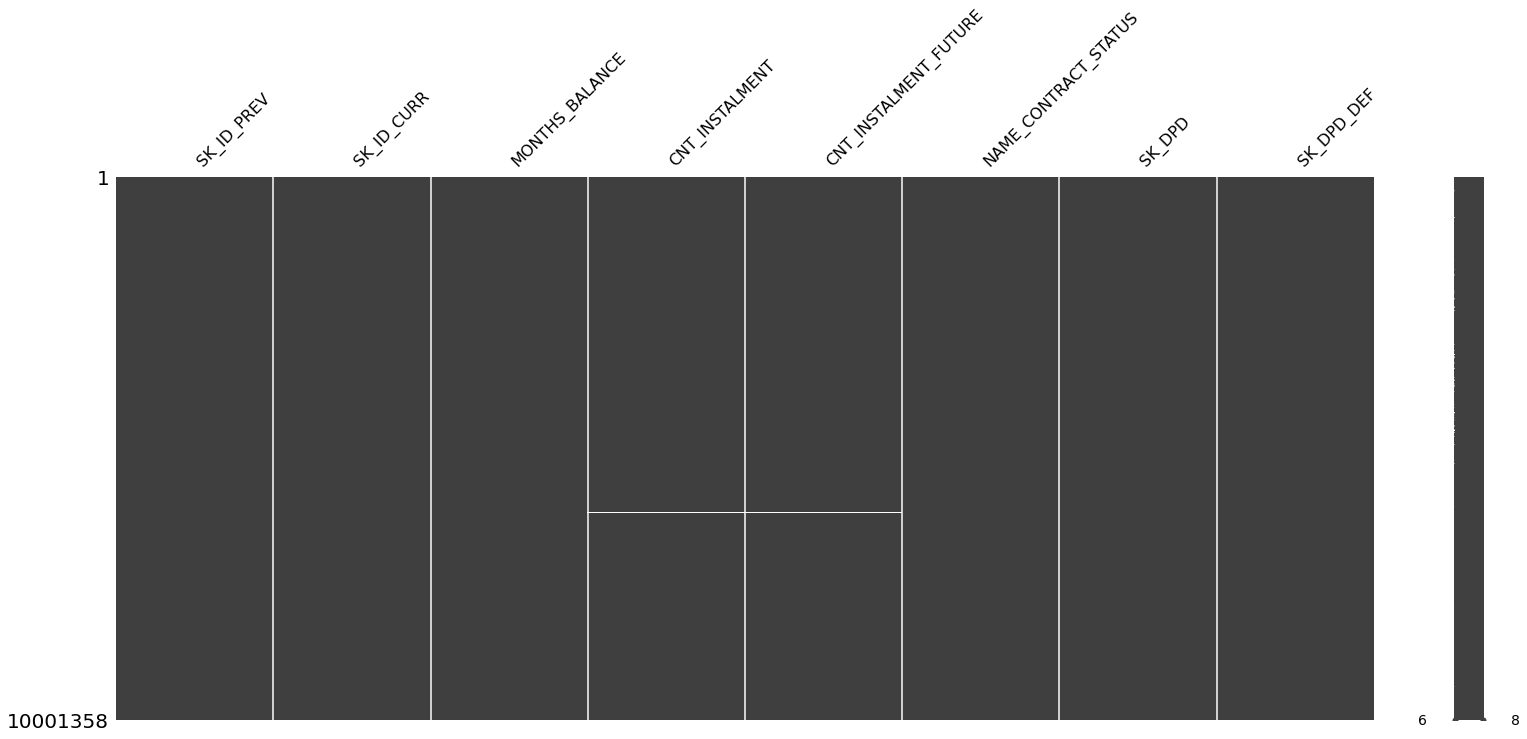

In [60]:
msno.matrix(pos)

In [61]:
(pos.isna().sum()/pos.shape[0]).sort_values(ascending=False)

CNT_INSTALMENT_FUTURE    0.002608
CNT_INSTALMENT           0.002607
SK_ID_PREV               0.000000
SK_ID_CURR               0.000000
MONTHS_BALANCE           0.000000
NAME_CONTRACT_STATUS     0.000000
SK_DPD                   0.000000
SK_DPD_DEF               0.000000
dtype: float64

In [62]:
pos_quali = pos.select_dtypes(exclude=np.number)
pos_quanti = pos.select_dtypes(include=np.number)
pos_quanti = pos_quanti.drop(['SK_ID_CURR', 'SK_ID_PREV'], axis=1)

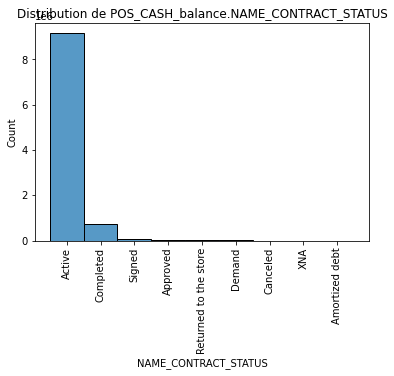

In [63]:
display_distri(pos_quali, dataset_name='POS_CASH_balance', quali=True)

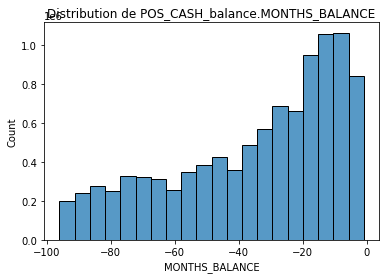

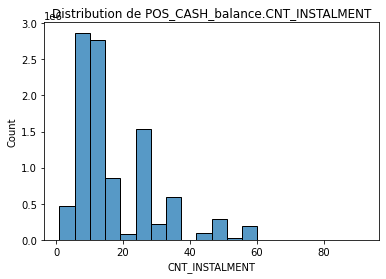

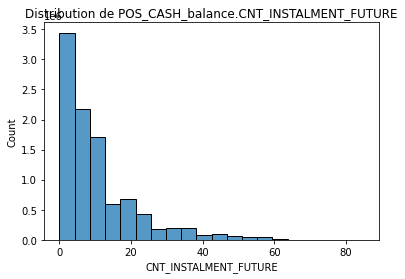

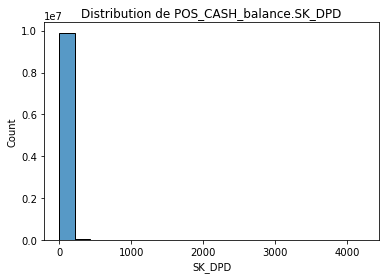

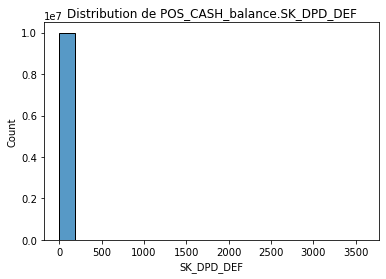

In [64]:
display_distri(pos_quanti, dataset_name='POS_CASH_balance', bins=20)

<AxesSubplot:>

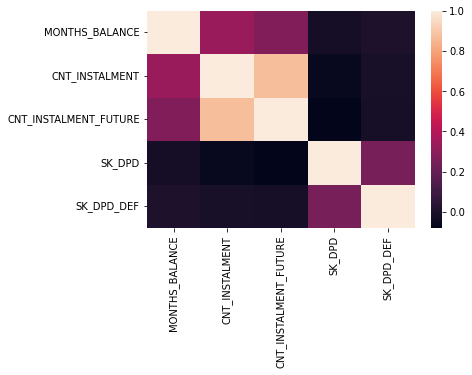

In [65]:
sns.heatmap(pos_quanti.corr())

In [66]:
simple = SimpleImputer(strategy='median')
pos_quanti_filled = pd.DataFrame(simple.fit_transform(pos_quanti), columns=pos_quanti.columns)
pos_quanti_filled.isna().sum().sum()

0

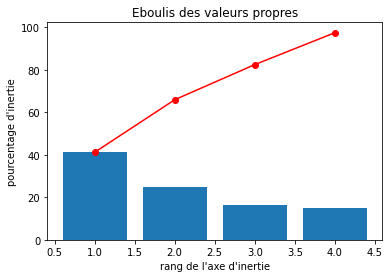

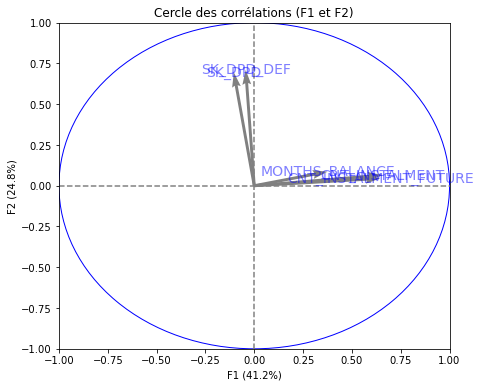

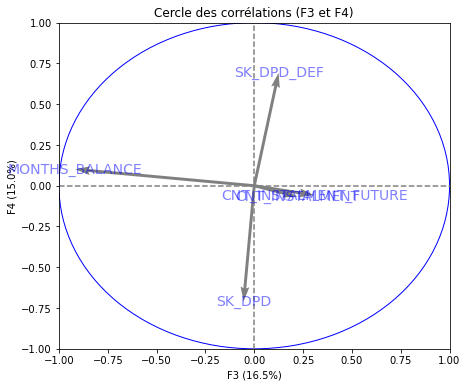

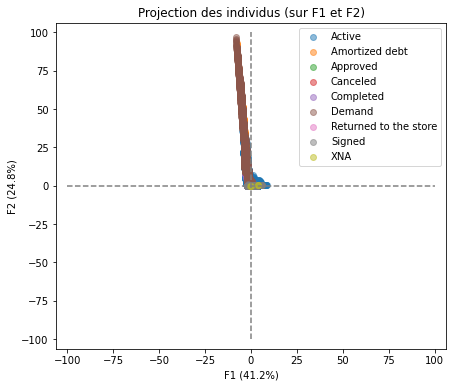

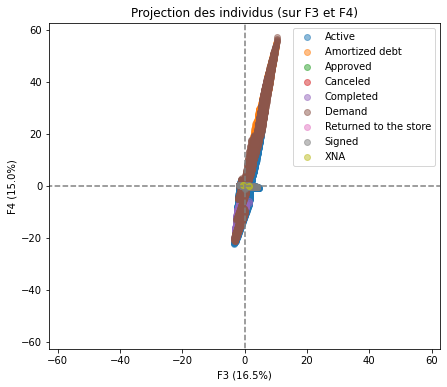

In [72]:
display_pca(pos_quanti_filled, split=pos[['NAME_CONTRACT_STATUS']], n_comp=4)

<div class="alert alert-block alert-info">
    <b><u>Analyse</u> : POS_CASH_Balance</b><br>
    
Les seules variables d'intérêt ici sont `CNT_INSTALMENT` et `CNT_INSTALMENT_FUTURE`, qui sont d'ailleurs formtement corrélées. On voit que le nombre de prêts en circulation décroît à mesure que le nombre de mensualités restant augmente.
    
    
</div>

[*(Retour sommaire)*](#ch0)

## <div id="ch2_6" style="color: orange;">2.6 Analyse : Installments_payments</div>

In [74]:
ins.shape

(13605401, 8)

In [75]:
ins.describe(include='all')

SK_ID_PREV    SK_ID_CURR  NUM_INSTALMENT_VERSION  \
count  1.360540e+07  1.360540e+07            1.360540e+07   
mean   1.903365e+06  2.784449e+05            8.566373e-01   
std    5.362029e+05  1.027183e+05            1.035216e+00   
min    1.000001e+06  1.000010e+05            0.000000e+00   
25%    1.434191e+06  1.896390e+05            0.000000e+00   
50%    1.896520e+06  2.786850e+05            1.000000e+00   
75%    2.369094e+06  3.675300e+05            1.000000e+00   
max    2.843499e+06  4.562550e+05            1.780000e+02   

       NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
count           1.360540e+07     1.360540e+07        1.360250e+07   
mean            1.887090e+01    -1.042270e+03       -1.051114e+03   
std             2.666407e+01     8.009463e+02        8.005859e+02   
min             1.000000e+00    -2.922000e+03       -4.921000e+03   
25%             4.000000e+00    -1.654000e+03       -1.662000e+03   
50%             8.000000e+00    -8.180000e+02       -8.270000e+02   
75%             1.900000e+01    -3.610000e+02       -3.700000e+02   
max             2.770000e+02    -1.000000e+00       -1.000000e+00   

       AMT_INSTALMENT   AMT_PAYMENT  
count    1.360540e+07  1.360250e+07  
mean     1.705091e+04  1.723822e+04  
std      5.057025e+04  5.473578e+04  
min      0.000000e+00  0.000000e+00  
25%      4.226085e+03  3.398265e+03  
50%      8.884080e+03  8.125515e+03  
75%      1.671021e+04  1.610842e+04  
max      3.771488e+06  3.771488e+06

In [76]:
ins.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

<AxesSubplot:>

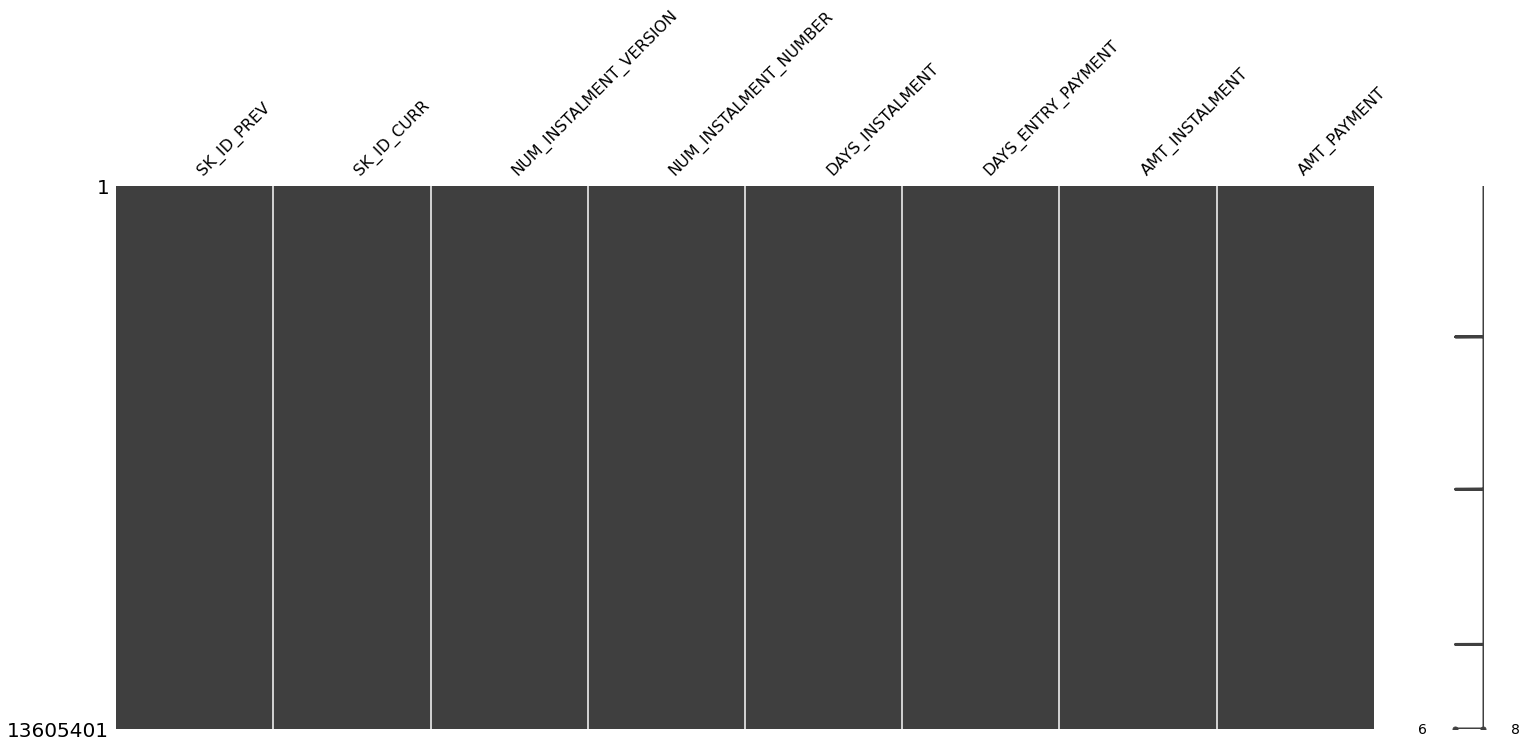

In [77]:
msno.matrix(ins)

In [78]:
(ins.isna().sum()/ins.shape[0]).sort_values(ascending=False)

DAYS_ENTRY_PAYMENT        0.000214
AMT_PAYMENT               0.000214
SK_ID_PREV                0.000000
SK_ID_CURR                0.000000
NUM_INSTALMENT_VERSION    0.000000
NUM_INSTALMENT_NUMBER     0.000000
DAYS_INSTALMENT           0.000000
AMT_INSTALMENT            0.000000
dtype: float64

In [79]:
ins_quanti = ins.drop(['SK_ID_CURR', 'SK_ID_PREV'], axis=1)

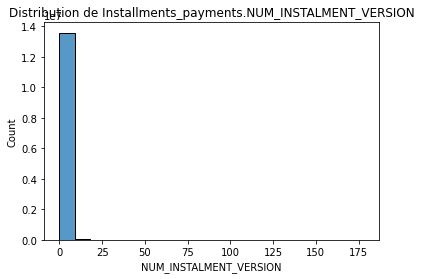

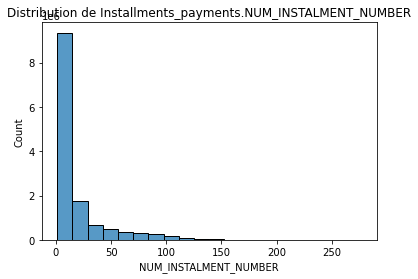

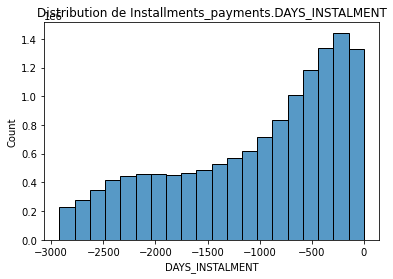

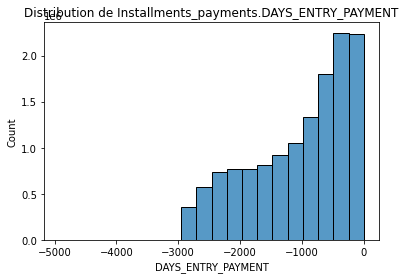

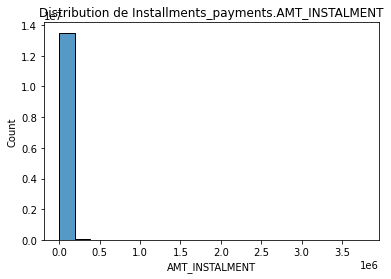

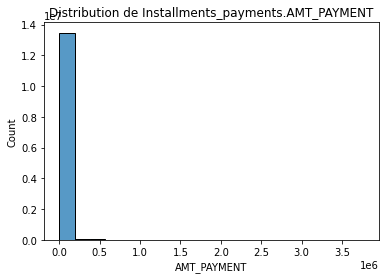

In [80]:
display_distri(ins_quanti, dataset_name='Installments_payments', bins=20)

<AxesSubplot:>

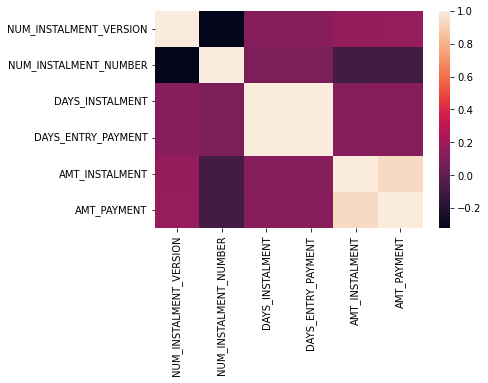

In [81]:
sns.heatmap(ins_quanti.corr())

In [82]:
simple = SimpleImputer(strategy='median')
ins_quanti_filled = pd.DataFrame(simple.fit_transform(ins_quanti), columns=ins_quanti.columns)
ins_quanti_filled.isna().sum().sum()

0

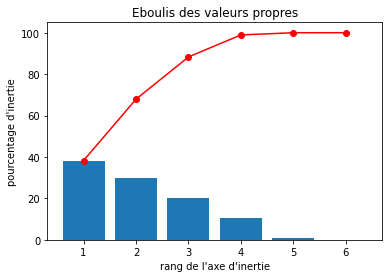

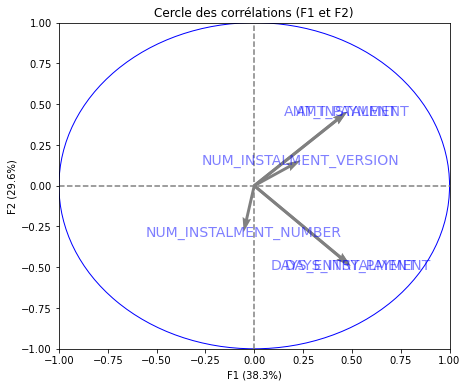

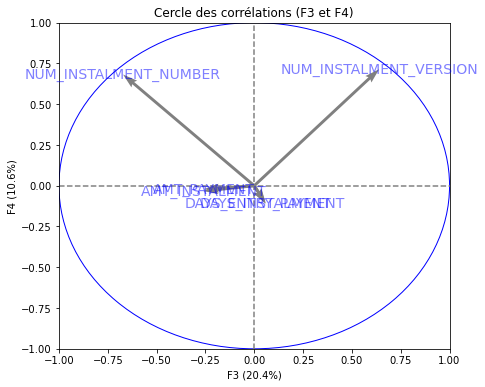

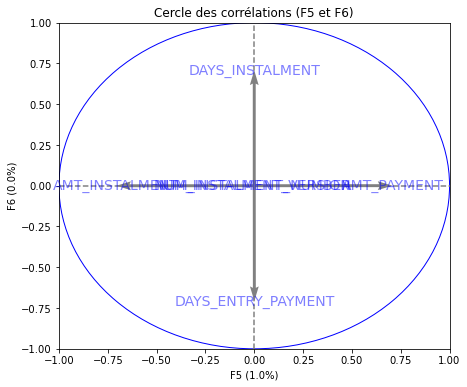

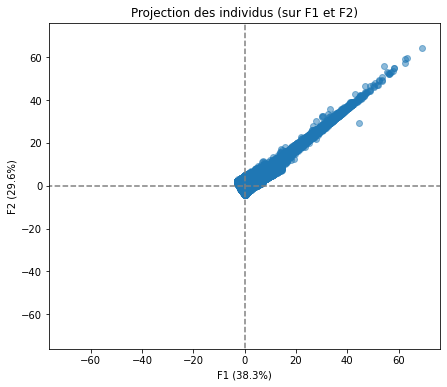

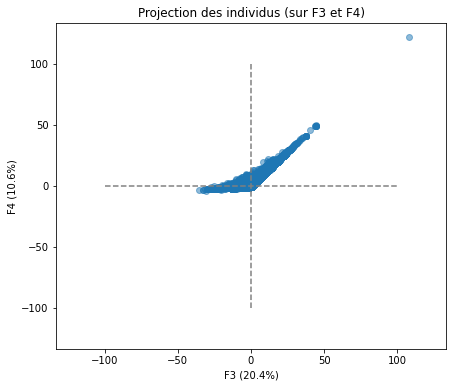

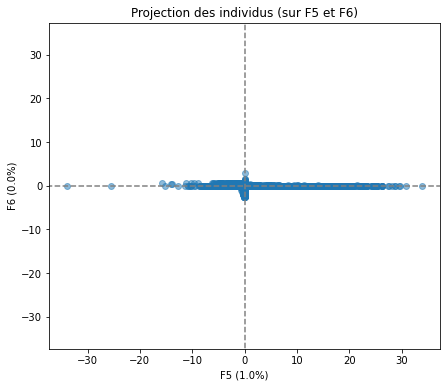

In [83]:
display_pca(ins_quanti_filled, n_comp=6)

<div class="alert alert-block alert-info">
    <b><u>Analyse</u> : Installments_Payments</b><br>
    
    
Les variables les plus intéressantes de cette table pour notre analyse sont `DAYS_INSTALMENT` et `AMT_INSTALMENT`. on remarque que ces deux variables présentent chacune de leur côté une forte corrélation avec deux autres variables, laissant imaginer une possible réduction de dimension.<br><br>
    
    
</div>

[*(Retour sommaire)*](#ch0)

## <div id="ch2_7" style="color: orange;">2.7 Analyse : Credit_card_balance</div>

In [85]:
cc_bal.shape

(3840312, 23)

In [86]:
cc_bal.describe(include='all')

SK_ID_PREV    SK_ID_CURR  MONTHS_BALANCE   AMT_BALANCE  \
count   3.840312e+06  3.840312e+06    3.840312e+06  3.840312e+06   
unique           NaN           NaN             NaN           NaN   
top              NaN           NaN             NaN           NaN   
freq             NaN           NaN             NaN           NaN   
mean    1.904504e+06  2.783242e+05   -3.452192e+01  5.830016e+04   
std     5.364695e+05  1.027045e+05    2.666775e+01  1.063070e+05   
min     1.000018e+06  1.000060e+05   -9.600000e+01 -4.202502e+05   
25%     1.434385e+06  1.895170e+05   -5.500000e+01  0.000000e+00   
50%     1.897122e+06  2.783960e+05   -2.800000e+01  0.000000e+00   
75%     2.369328e+06  3.675800e+05   -1.100000e+01  8.904669e+04   
max     2.843496e+06  4.562500e+05   -1.000000e+00  1.505902e+06   

        AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  \
count              3.840312e+06              3.090496e+06   
unique                      NaN                       NaN   
top                         NaN                       NaN   
freq                        NaN                       NaN   
mean               1.538080e+05              5.961325e+03   
std                1.651457e+05              2.822569e+04   
min                0.000000e+00             -6.827310e+03   
25%                4.500000e+04              0.000000e+00   
50%                1.125000e+05              0.000000e+00   
75%                1.800000e+05              0.000000e+00   
max                1.350000e+06              2.115000e+06   

        AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  \
count           3.840312e+06                3.090496e+06   
unique                   NaN                         NaN   
top                      NaN                         NaN   
freq                     NaN                         NaN   
mean            7.433388e+03                2.881696e+02   
std             3.384608e+04                8.201989e+03   
min            -6.211620e+03                0.000000e+00   
25%             0.000000e+00                0.000000e+00   
50%             0.000000e+00                0.000000e+00   
75%             0.000000e+00                0.000000e+00   
max             2.287098e+06                1.529847e+06   

        AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  \
count               3.090496e+06             3.535076e+06   
unique                       NaN                      NaN   
top                          NaN                      NaN   
freq                         NaN                      NaN   
mean                2.968805e+03             3.540204e+03   
std                 2.079689e+04             5.600154e+03   
min                 0.000000e+00             0.000000e+00   
25%                 0.000000e+00             0.000000e+00   
50%                 0.000000e+00             0.000000e+00   
75%                 0.000000e+00             6.633911e+03   
max                 2.239274e+06             2.028820e+05   

        AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
count          3.072324e+06               3.840312e+06   
unique                  NaN                        NaN   
top                     NaN                        NaN   
freq                    NaN                        NaN   
mean           1.028054e+04               7.588857e+03   
std            3.607808e+04               3.200599e+04   
min            0.000000e+00               0.000000e+00   
25%            1.523700e+02               0.000000e+00   
50%            2.702700e+03               0.000000e+00   
75%            9.000000e+03               6.750000e+03   
max            4.289207e+06               4.278316e+06   

        AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
count               3.840312e+06   3.840312e+06          3.840312e+06   
unique                       NaN            NaN                   NaN   
top                          NaN            NaN                   NaN   
freq             

In [87]:
cc_bal.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 1700.325               1800.0                     1800.0   
1                 2250.000               2250.0                     2250.0   
2                 2250.000               2250.0                     2250.0   
3                11795.760              11925.0                    11925.0   
4                22924.890              27000.0                    27000.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                     0.000          0.000                 0.000   
1                 60175.080      64875.555             64875.555   
2                 26926.425      31460.085             31460.085   
3                224949.285     233048.970            233048.970   
4                443044.395     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   
1                       0.0                       69.0               Active   
2                       0.0                       30.0               Active   
3                       0.0                       10.0               Active   
4                       1.0                      101.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

<AxesSubplot:>

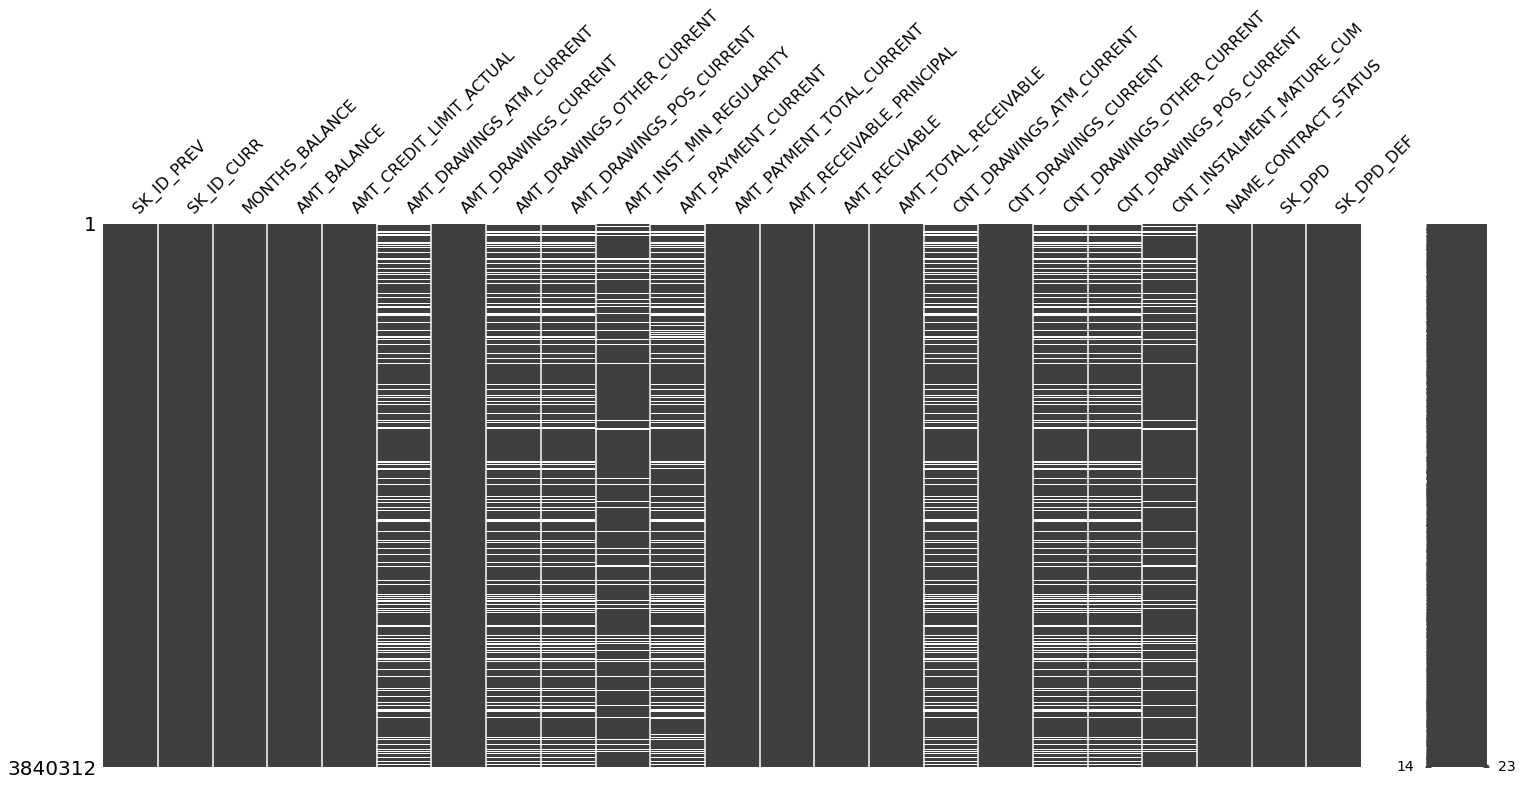

In [88]:
msno.matrix(cc_bal)

In [89]:
(cc_bal.isna().sum()/cc_bal.shape[0]).sort_values(ascending=False)

AMT_PAYMENT_CURRENT           0.199981
AMT_DRAWINGS_ATM_CURRENT      0.195249
CNT_DRAWINGS_POS_CURRENT      0.195249
AMT_DRAWINGS_OTHER_CURRENT    0.195249
AMT_DRAWINGS_POS_CURRENT      0.195249
CNT_DRAWINGS_OTHER_CURRENT    0.195249
CNT_DRAWINGS_ATM_CURRENT      0.195249
CNT_INSTALMENT_MATURE_CUM     0.079482
AMT_INST_MIN_REGULARITY       0.079482
SK_ID_PREV                    0.000000
AMT_TOTAL_RECEIVABLE          0.000000
SK_DPD                        0.000000
NAME_CONTRACT_STATUS          0.000000
CNT_DRAWINGS_CURRENT          0.000000
AMT_PAYMENT_TOTAL_CURRENT     0.000000
AMT_RECIVABLE                 0.000000
AMT_RECEIVABLE_PRINCIPAL      0.000000
SK_ID_CURR                    0.000000
AMT_DRAWINGS_CURRENT          0.000000
AMT_CREDIT_LIMIT_ACTUAL       0.000000
AMT_BALANCE                   0.000000
MONTHS_BALANCE                0.000000
SK_DPD_DEF                    0.000000
dtype: float64

In [90]:
cc_bal_quali = cc_bal.select_dtypes(exclude=np.number)
cc_bal_quanti = cc_bal.select_dtypes(include=np.number)
cc_bal_quanti = cc_bal_quanti.drop(['SK_ID_CURR', 'SK_ID_PREV'], axis=1)

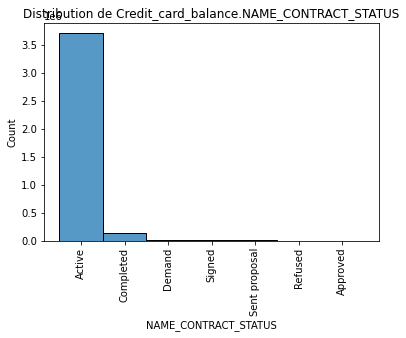

In [91]:
display_distri(cc_bal_quali, dataset_name='Credit_card_balance', quali=True)

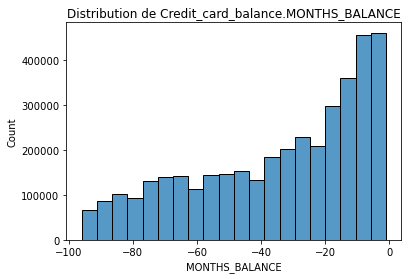

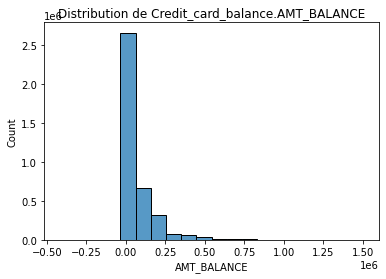

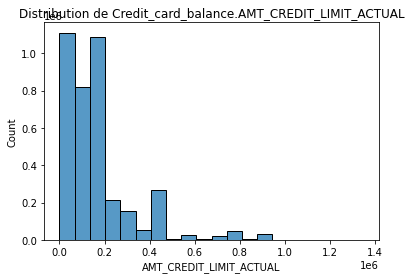

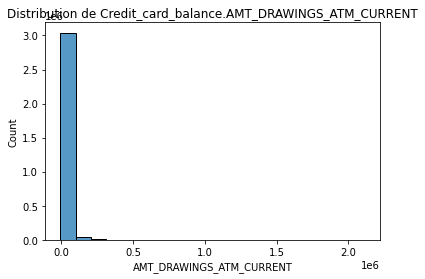

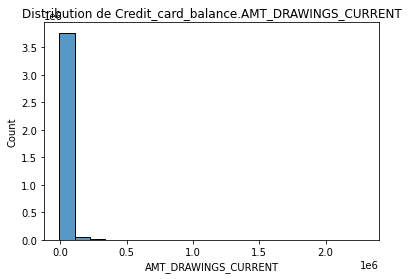

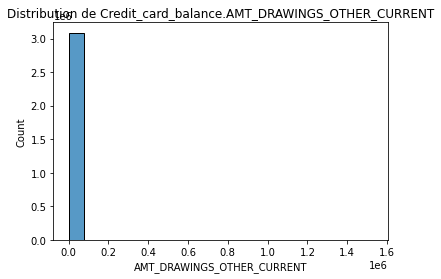

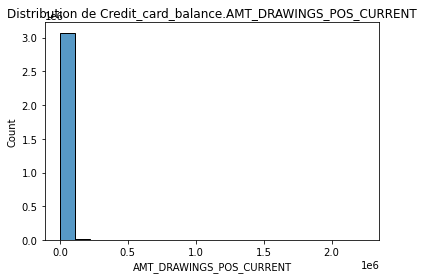

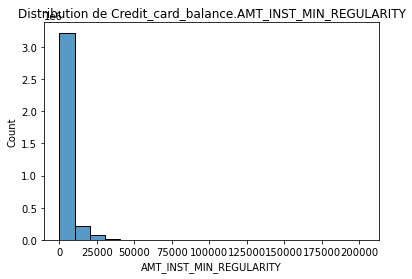

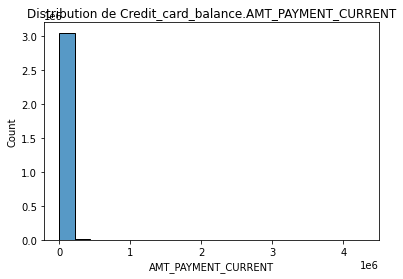

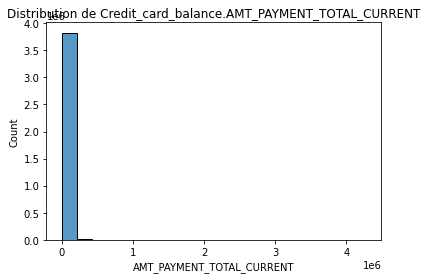

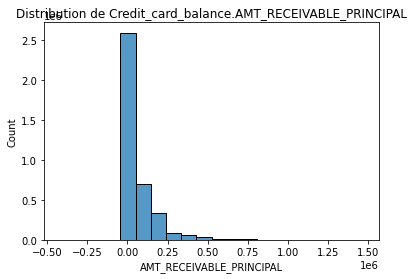

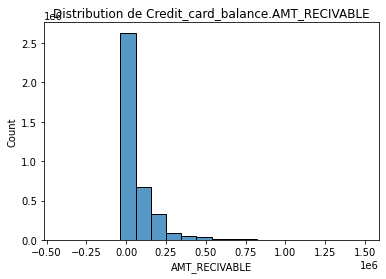

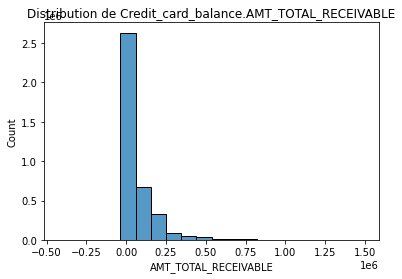

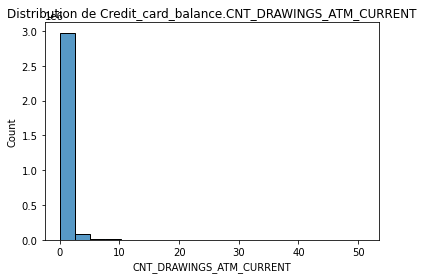

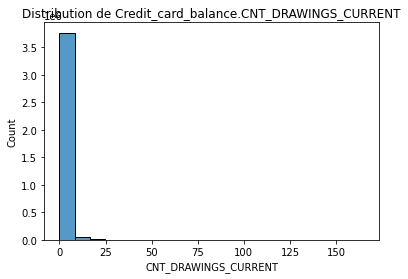

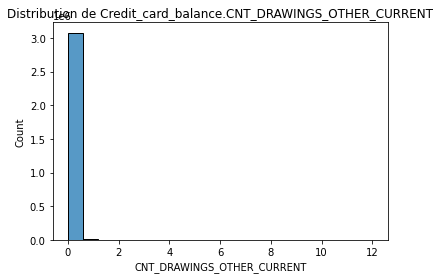

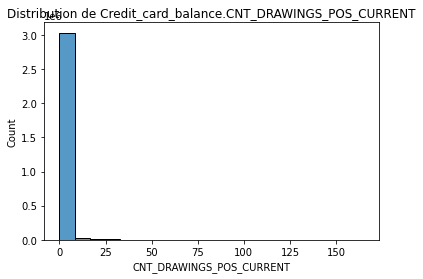

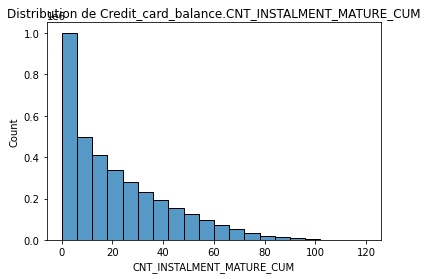

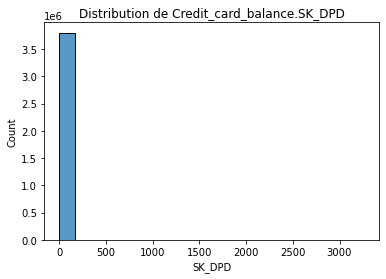

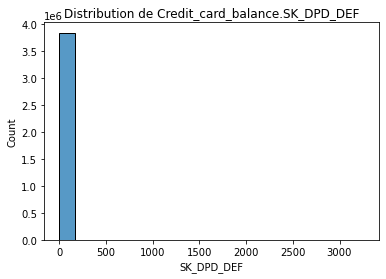

In [92]:
display_distri(cc_bal_quanti, dataset_name='Credit_card_balance', bins=20)

<AxesSubplot:>

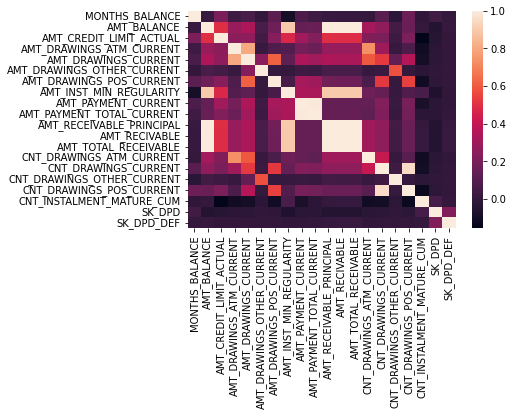

In [93]:
sns.heatmap(cc_bal_quanti.corr())

In [94]:
simple = SimpleImputer(strategy='median')
cc_bal_quanti_filled = pd.DataFrame(simple.fit_transform(cc_bal_quanti), columns=cc_bal_quanti.columns)
cc_bal_quanti_filled.isna().sum().sum()

0

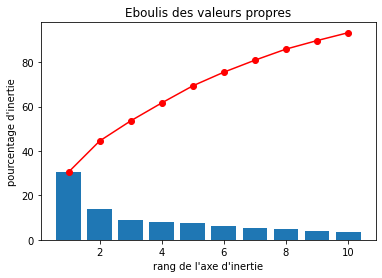

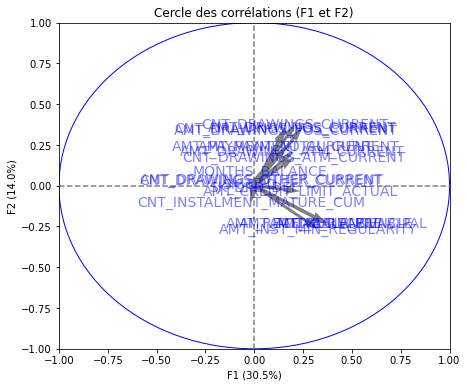

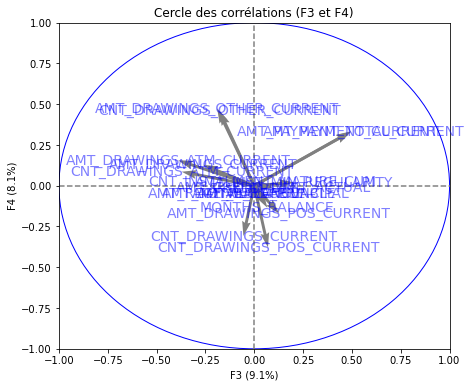

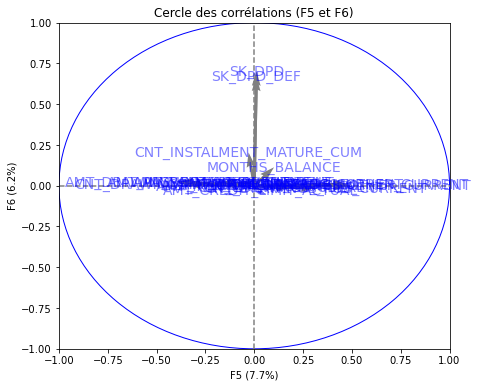

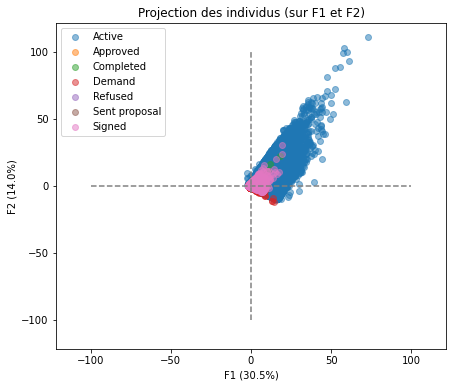

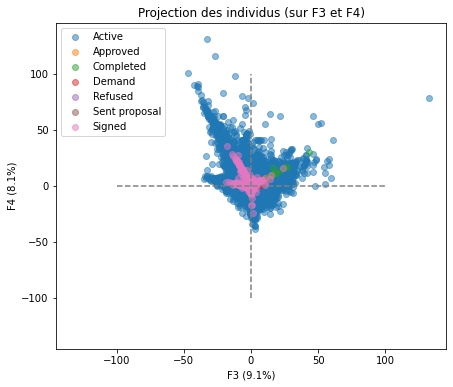

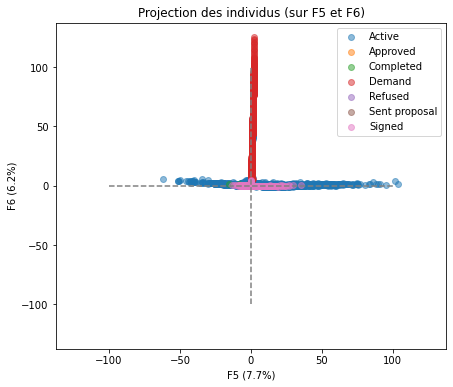

In [96]:
display_pca(cc_bal_quanti_filled, split=cc_bal[['NAME_CONTRACT_STATUS']], n_comp=10)

<div class="alert alert-block alert-info">
    <b><u>Analyse</u> : Credit_Card_Balance</b><br>
    
Les distributions des variables de cette table sont globalement très concentrées, et semble ne pas pouvoir fournir grand support dans la tâche de prédiction. `CNT_INSTALMENT_MATURE_CUM` présente toutefois intuitivement un intérêt métier, car on pourrait s'attendre à ce que plus le nombre de remboursement ont été honoré, plus le remboursement du crédit est susceptible d'être complété.
    
    
</div>

[*(Retour sommaire)*](#ch0)

## <div id="ch2_8" style="color: orange;">2.8 Analyse : Application</div>

In [592]:
#Source : https://www.kaggle.com/code/willkoehrsen/automated-feature-engineering-basics/notebook

In [6]:
app.shape

(307511, 122)

In [13]:
app.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [14]:
app.describe(include='all')

SK_ID_CURR         TARGET NAME_CONTRACT_TYPE CODE_GENDER  \
count   307511.000000  307511.000000             307511      307511   
unique            NaN            NaN                  2           3   
top               NaN            NaN         Cash loans           F   
freq              NaN            NaN             278232      202448   
mean    278180.518577       0.080729                NaN         NaN   
std     102790.175348       0.272419                NaN         NaN   
min     100002.000000       0.000000                NaN         NaN   
25%     189145.500000       0.000000                NaN         NaN   
50%     278202.000000       0.000000                NaN         NaN   
75%     367142.500000       0.000000                NaN         NaN   
max     456255.000000       1.000000                NaN         NaN   

       FLAG_OWN_CAR FLAG_OWN_REALTY   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count        307511          307511  307511.000000      3.075110e+05   
unique            2               2            NaN               NaN   
top               N               Y            NaN               NaN   
freq         202924          213312            NaN               NaN   
mean            NaN             NaN       0.417052      1.687979e+05   
std             NaN             NaN       0.722121      2.371231e+05   
min             NaN             NaN       0.000000      2.565000e+04   
25%             NaN             NaN       0.000000      1.125000e+05   
50%             NaN             NaN       0.000000      1.471500e+05   
75%             NaN             NaN       1.000000      2.025000e+05   
max             NaN             NaN      19.000000      1.170000e+08   

          AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE  \
count   3.075110e+05  307499.000000     3.072330e+05          306219   
unique           NaN            NaN              NaN               7   
top              NaN            NaN              NaN   Unaccompanied   
freq             NaN            NaN              NaN          248526   
mean    5.990260e+05   27108.573909     5.383962e+05             NaN   
std     4.024908e+05   14493.737315     3.694465e+05             NaN   
min     4.500000e+04    1615.500000     4.050000e+04             NaN   
25%     2.700000e+05   16524.000000     2.385000e+05             NaN   
50%     5.135310e+05   24903.000000     4.500000e+05             NaN   
75%     8.086500e+05   34596.000000     6.795000e+05             NaN   
max     4.050000e+06  258025.500000     4.050000e+06             NaN   

       NAME_INCOME_TYPE            NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  \
count            307511                         307511             307511   
unique                8                              5                  6   
top             Working  Secondary / secondary special            Married   
freq             158774                         218391             196432   
mean                NaN                            NaN                NaN   
std                 NaN                            NaN                NaN   
min                 NaN                            NaN                NaN   
25%                 NaN                            NaN                NaN   
50%                 NaN                            NaN                NaN   
75%                 NaN                            NaN                NaN   
max                 NaN                            NaN                NaN   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE     DAYS_BIRTH  \
count              307511               307511.000000  307511.000000   
unique                  6                         NaN            NaN   
top     House / apartment                         NaN            NaN   
freq               272868                         NaN            NaN   
mean                  NaN                    0.020868  -16036.995067   
std                   NaN                    0.013831    4363.988632   

<AxesSubplot:>

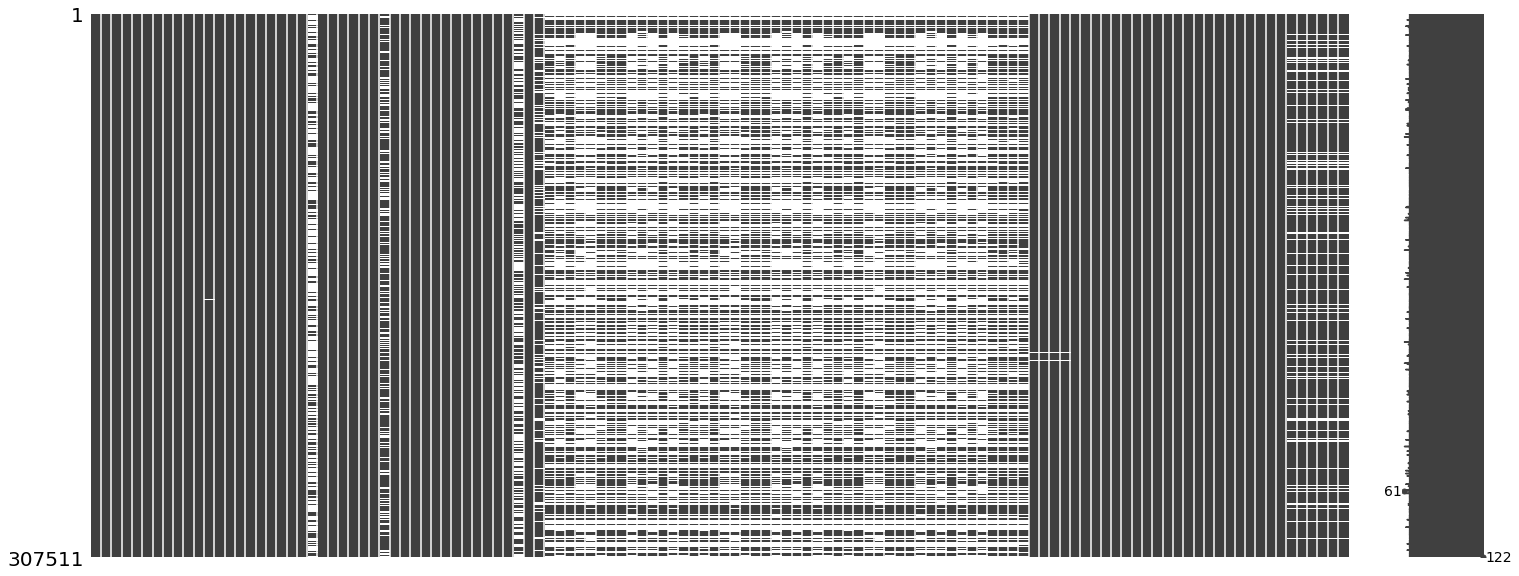

In [10]:
msno.matrix(app)

In [20]:
(app.isna().sum()/app.shape[0]).sort_values(ascending=False)

COMMONAREA_MEDI                 0.698723
COMMONAREA_AVG                  0.698723
COMMONAREA_MODE                 0.698723
NONLIVINGAPARTMENTS_MODE        0.694330
NONLIVINGAPARTMENTS_AVG         0.694330
NONLIVINGAPARTMENTS_MEDI        0.694330
FONDKAPREMONT_MODE              0.683862
LIVINGAPARTMENTS_MODE           0.683550
LIVINGAPARTMENTS_AVG            0.683550
LIVINGAPARTMENTS_MEDI           0.683550
FLOORSMIN_AVG                   0.678486
FLOORSMIN_MODE                  0.678486
FLOORSMIN_MEDI                  0.678486
YEARS_BUILD_MEDI                0.664978
YEARS_BUILD_MODE                0.664978
YEARS_BUILD_AVG                 0.664978
OWN_CAR_AGE                     0.659908
LANDAREA_MEDI                   0.593767
LANDAREA_MODE                   0.593767
LANDAREA_AVG                    0.593767
BASEMENTAREA_MEDI               0.585160
BASEMENTAREA_AVG                0.585160
BASEMENTAREA_MODE               0.585160
EXT_SOURCE_1                    0.563811
NONLIVINGAREA_MO

In [15]:
app['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

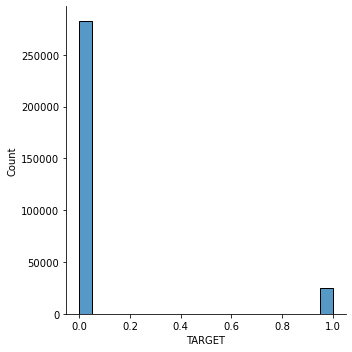

In [18]:
sns.displot(data=app['TARGET'])

In [34]:
(app['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [35]:
app['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

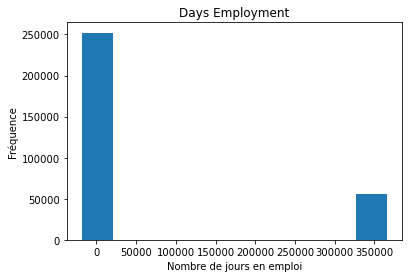

In [41]:
app['DAYS_EMPLOYED'].plot.hist(title = 'Nombre de jours en emploi')
plt.xlabel('DAYS_EMPLOYED')
plt.ylabel('Fréquence')
plt.show()

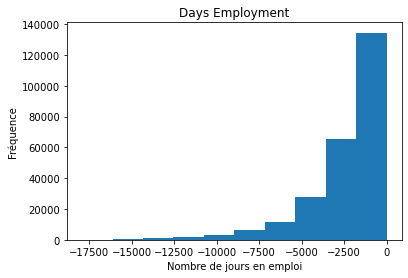

In [44]:
app['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app['DAYS_EMPLOYED'].plot.hist(title = 'Nombre de jours en emploi')
plt.xlabel('DAYS_EMPLOYED')
plt.ylabel('Fréquence')
plt.show()

In [51]:
correlations_lineaires = app.corr()['TARGET'].sort_values()
print('Corrélations positives les plus fortes :')
print(correlations_lineaires.tail(15).sort_values(ascending=False))
print()
print('Corrélations négatives les plus fortes :')
print(correlations_lineaires.head(15))

Corrélations positives les plus fortes :
TARGET                                               1.000000
DAYS_BIRTH                                           0.078239
DAYS_EMPLOYED                                        0.074958
REGION_RATING_CLIENT_W_CITY                          0.060893
REGION_RATING_CLIENT                                 0.058899
NAME_INCOME_TYPE_Working                             0.057481
DAYS_LAST_PHONE_CHANGE                               0.055218
CODE_GENDER_M                                        0.054713
DAYS_ID_PUBLISH                                      0.051457
REG_CITY_NOT_WORK_CITY                               0.050994
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
FLAG_EMP_PHONE                                       0.045982
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_DOCUMENT_3                                      0.044346
OCCUPATION_TYPE_Laborers                             0.043019
Name: TARGET, dtype: float64


In [52]:
app['DAYS_BIRTH'].corr(app['TARGET'])

-0.07823930830982712

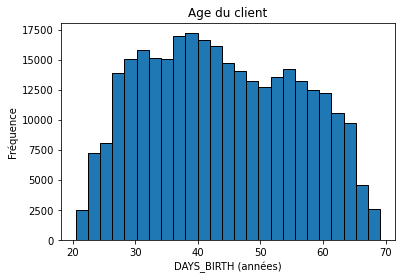

In [55]:
(app['DAYS_BIRTH'] / -365).plot.hist(title = 'Age du client', bins=25, edgecolor='k')
plt.xlabel('DAYS_BIRTH (années)')
plt.ylabel('Fréquence')
plt.show()

Text(0.5, 1.0, 'Distribution des âges')

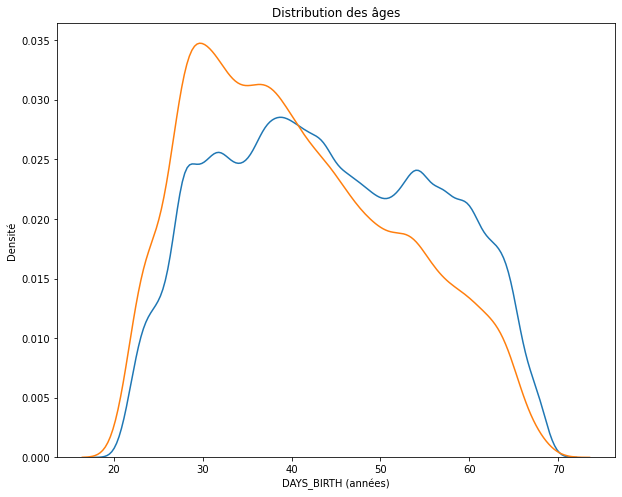

In [56]:
plt.figure(figsize = (10, 8))
sns.kdeplot((app.loc[app['TARGET'] == 0, 'DAYS_BIRTH']) / -365, label='TARGET == 0')
sns.kdeplot((app.loc[app['TARGET'] == 1, 'DAYS_BIRTH']) / -365, label = 'TARGET == 1')
plt.xlabel('DAYS_BIRTH (années)')
plt.ylabel('Densité'); plt.title('Distribution des âges')

In [60]:
age_data.head(5)

TARGET  DAYS_BIRTH
0       1        9461
1       0       16765
2       0       19046
3       0       19005
4       0       19932

In [67]:
age_data = app[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / -365
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins=np.linspace(20, 70, num=11))
age_data.head(10)

C:\Users\aledo\AppData\Local\Temp\ipykernel_12200\3906063866.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365
C:\Users\aledo\AppData\Local\Temp\ipykernel_12200\3906063866.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins=np.linspace(20, 70, num=11))


TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.920548  (25.0, 30.0]
1       0       16765    45.931507  (45.0, 50.0]
2       0       19046    52.180822  (50.0, 55.0]
3       0       19005    52.068493  (50.0, 55.0]
4       0       19932    54.608219  (50.0, 55.0]
5       0       16941    46.413699  (45.0, 50.0]
6       0       13778    37.747945  (35.0, 40.0]
7       0       18850    51.643836  (50.0, 55.0]
8       0       20099    55.065753  (55.0, 60.0]
9       0       14469    39.641096  (35.0, 40.0]

In [68]:
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111436  10155.219250    27.822518
(30.0, 35.0]  0.102814  11854.848377    32.479037
(35.0, 40.0]  0.089414  13707.908253    37.555913
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055314  20984.262742    57.491131
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

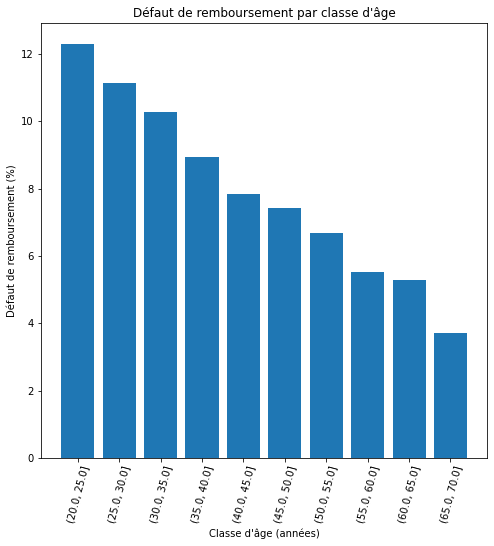

In [69]:
plt.figure(figsize = (8, 8))
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])
plt.xticks(rotation = 75)
plt.xlabel("Classe d'âge (années)")
plt.ylabel("Défaut de remboursement (%)")
plt.title("Défaut de remboursement par classe d'âge")
plt.show()

In [70]:
ext_data = app[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_correlations = ext_data.corr()
ext_data_correlations

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000

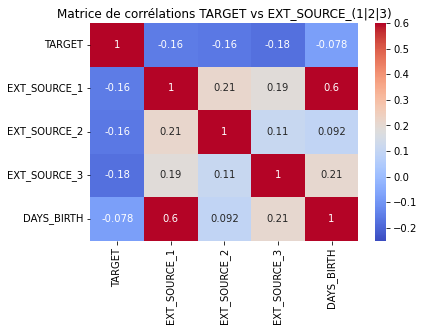

In [71]:
sns.heatmap(ext_data_correlations, cmap='coolwarm', vmin=-0.25, annot=True, vmax=0.6)
plt.title('Matrice de corrélations TARGET vs EXT_SOURCE_(1|2|3)');

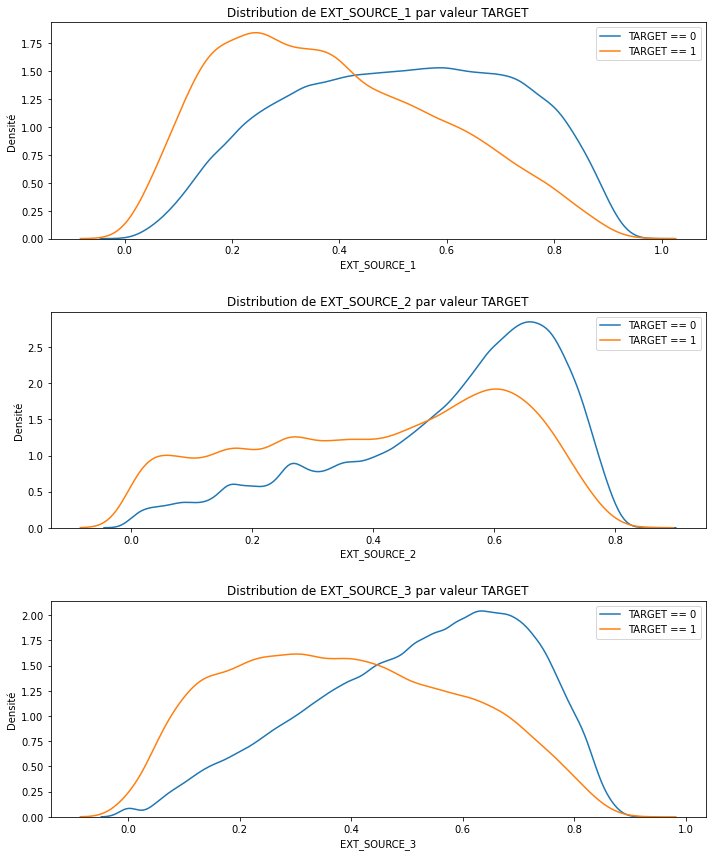

In [74]:
plt.figure(figsize = (10, 12))
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    plt.subplot(3, 1, i + 1)
    sns.kdeplot(app.loc[app['TARGET'] == 0, source], label = 'TARGET == 0')
    sns.kdeplot(app.loc[app['TARGET'] == 1, source], label = 'TARGET == 1')
    plt.title(f"Distribution de {source} par valeur TARGET")
    plt.xlabel(source)
    plt.ylabel('Densité')
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)

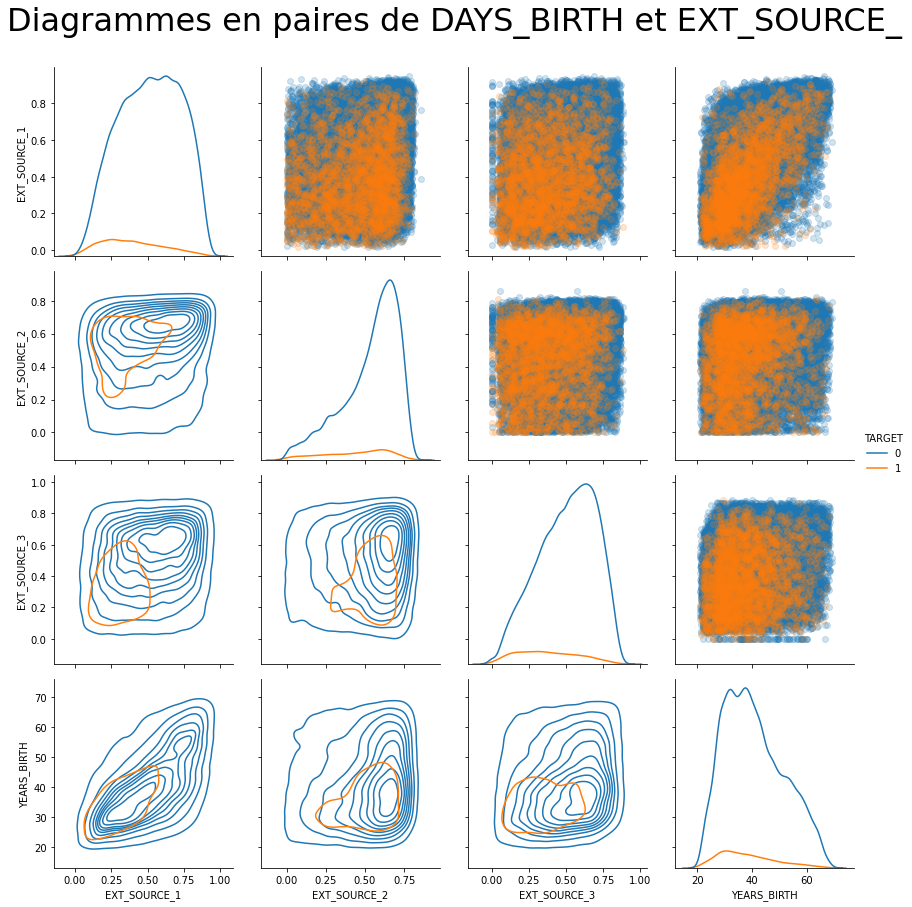

In [80]:
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']
plot_data = plot_data.dropna().loc[:100000, :]

def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r), xy=(.2, .8), xycoords=ax.transAxes, height=20)

grid = sns.PairGrid(data=plot_data, height=3, diag_sharey=False, hue='TARGET', 
                    vars=[x for x in list(plot_data.columns) if x != 'TARGET'])
grid.map_upper(plt.scatter, alpha=0.2)
grid.map_diag(sns.kdeplot)
grid.map_lower(sns.kdeplot)
grid.add_legend()
plt.suptitle('Diagrammes en paires de DAYS_BIRTH et EXT_SOURCE_', size=20, y=1.05)
plt.show()

[*(Retour sommaire)*](#ch0)

# <div id="ch3" style="color: blue;">3. Feature engineering</div>

Nous allons effectuer différents traitements à notre jeu de données afin de comparer les approches de feature engeneering :

- **Valeur statistiques** : ajout de nouvelles variables par calcul de métriques statistiques simples (rapport, minimum, moyenne, etc.) puis aggrégation de toutes les tables en un seul jeu de données
- **Traitement automatisé** : mise en place de valeurs statistiques à l'aide de l'outil de feature engeneering automatisé FeatureTools puis aggrégation de toutes les tables en un seul jeu de données
- **Encodage simple** des données de la seule table `application_train`, servant de baseline

L'encodage des variables quanlitatives sera réalisée à l'aide d'un LabelEncoder pour les valeurs binaires, et en encodage One-hot pour les variables prenant au moins trois valeurs distinctes.

## <div id="ch3_1" style="color: orange;">3.1 Valeurs statistiques</div>

In [590]:
#Source : https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

In [52]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [53]:
app_stat = app.copy()
bur_stat = bur.copy()
prev_stat = prev.copy()
bur_bal_stat = bur_bal.copy()
pos_stat = pos.copy()
ins_stat = ins.copy()
cc_bal_stat = cc_bal.copy()

In [54]:
# Preprocessing Application_train
app_stat = app_stat[app_stat['CODE_GENDER'] != 'XNA']
for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    app_stat[bin_feature], uniques = pd.factorize(app_stat[bin_feature])
app_stat, cat_cols = one_hot_encoder(app_stat)
app_stat['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
app_stat['DAYS_EMPLOYED_PERC'] = app_stat['DAYS_EMPLOYED'] / app_stat['DAYS_BIRTH']
app_stat['INCOME_CREDIT_PERC'] = app_stat['AMT_INCOME_TOTAL'] / app_stat['AMT_CREDIT']
app_stat['INCOME_PER_PERSON'] = app_stat['AMT_INCOME_TOTAL'] / app_stat['CNT_FAM_MEMBERS']
app_stat['ANNUITY_INCOME_PERC'] = app_stat['AMT_ANNUITY'] / app_stat['AMT_INCOME_TOTAL']
app_stat['PAYMENT_RATE'] = app_stat['AMT_ANNUITY'] / app_stat['AMT_CREDIT']

In [55]:
# Preprocessing Bureau & Bureau_balance
bur_bal_stat, bur_bal_cat = one_hot_encoder(bur_bal_stat)
bur_stat, bur_cat = one_hot_encoder(bur_stat)
bur_bal_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
for col in bur_bal_cat:
    bur_bal_aggregations[col] = ['mean']
bur_bal_agg = bur_bal_stat.groupby('SK_ID_BUREAU').agg(bur_bal_aggregations)
bur_bal_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bur_bal_agg.columns.tolist()])
bur_stat = bur_stat.join(bur_bal_agg, how='left', on='SK_ID_BUREAU')
bur_stat.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
del bur_bal_stat, bur_bal_agg
gc.collect()
num_aggregations = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}
cat_aggregations = {}
for cat in bur_cat: cat_aggregations[cat] = ['mean']
for cat in bur_bal_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
bur_agg = bur_stat.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bur_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bur_agg.columns.tolist()])
active = bur_stat[bur_stat['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bur_agg = bur_agg.join(active_agg, how='left', on='SK_ID_CURR')
del active, active_agg
gc.collect()
closed = bur_stat[bur_stat['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bur_agg = bur_agg.join(closed_agg, how='left', on='SK_ID_CURR')
del closed, closed_agg, bur_stat
gc.collect()
app_stat = app_stat.join(bur_agg, how='left', on='SK_ID_CURR')
del bur_agg
gc.collect()

0

In [56]:
# Preprocessing Previous_applications
prev_stat, cat_cols = one_hot_encoder(prev_stat)
prev_stat['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
prev_stat['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
prev_stat['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
prev_stat['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
prev_stat['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
prev_stat['APP_CREDIT_PERC'] = prev_stat['AMT_APPLICATION'] / prev_stat['AMT_CREDIT']
num_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_APPLICATION': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
}
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']
prev_agg = prev_stat.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
approved = prev_stat[prev_stat['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
refused = prev_stat[prev_stat['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
del refused, refused_agg, approved, approved_agg, prev_stat
gc.collect()
app_stat = app_stat.join(prev_agg, how='left', on='SK_ID_CURR')
del prev_agg
gc.collect()

0

In [57]:
# Preprocessing POS_CASH_balance
pos_stat, cat_cols = one_hot_encoder(pos_stat)
aggregations = {
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']
pos_agg = pos_stat.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
pos_agg['POS_COUNT'] = pos_stat.groupby('SK_ID_CURR').size()
del pos_stat
gc.collect()
app_stat = app_stat.join(pos_agg, how='left', on='SK_ID_CURR')
del pos_agg
gc.collect()

0

In [58]:
# Preprocessing Installments_payments
ins_stat, cat_cols = one_hot_encoder(ins_stat)
ins_stat['PAYMENT_PERC'] = ins_stat['AMT_PAYMENT'] / ins_stat['AMT_INSTALMENT']
ins_stat['PAYMENT_DIFF'] = ins_stat['AMT_INSTALMENT'] - ins_stat['AMT_PAYMENT']
ins_stat['DPD'] = ins_stat['DAYS_ENTRY_PAYMENT'] - ins_stat['DAYS_INSTALMENT']
ins_stat['DBD'] = ins_stat['DAYS_INSTALMENT'] - ins_stat['DAYS_ENTRY_PAYMENT']
ins_stat['DPD'] = ins_stat['DPD'].apply(lambda x: x if x > 0 else 0)
ins_stat['DBD'] = ins_stat['DBD'].apply(lambda x: x if x > 0 else 0)
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'DPD': ['max', 'mean', 'sum'],
    'DBD': ['max', 'mean', 'sum'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']
ins_agg = ins_stat.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
ins_agg['INSTAL_COUNT'] = ins_stat.groupby('SK_ID_CURR').size()
del ins_stat
gc.collect()
app_stat = app_stat.join(ins_agg, how='left', on='SK_ID_CURR')
del ins_agg
gc.collect()

0

In [59]:
# Preprocessing Credit_card_balance
cc_bal_stat, cat_cols = one_hot_encoder(cc_bal_stat)
cc_bal_stat.drop(['SK_ID_PREV'], axis=1, inplace=True)
cc_agg = cc_bal_stat.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
cc_agg['CC_COUNT'] = cc_bal_stat.groupby('SK_ID_CURR').size()
del cc_bal_stat
gc.collect()
app_stat = app_stat.join(cc_agg, how='left', on='SK_ID_CURR')
del cc_agg
gc.collect()

0

In [60]:
app_stat.to_csv('statistics.csv', index=False)
statistics = app_stat.copy()
del app_stat
gc.collect()

0

In [61]:
statistics.shape

(307507, 810)

[*(Retour sommaire)*](#ch0)

## <div id="ch3_2" style="color: orange;">3.2 Feature engineering automatisé</div>

In [592]:
#Source : https://www.kaggle.com/code/willkoehrsen/automated-feature-engineering-basics/notebook

In [30]:
app_aut = app.copy()
bur_aut = bur.copy()
prev_aut = prev.copy()
bur_bal_aut = bur_bal.copy()
pos_aut = pos.copy()
ins_aut = ins.copy()
cc_bal_aut = cc_bal.copy()

In [31]:
def replace_day_outliers(df):
    for col in df.columns:
        if "DAYS" in col:
            df[col] = df[col].replace({365243: np.nan})
    return df

In [32]:
app_aut = replace_day_outliers(app_aut)
bur_aut = replace_day_outliers(bur_aut)
bur_bal_aut = replace_day_outliers(bur_bal_aut)
cc_bal_aut = replace_day_outliers(cc_bal_aut)
pos_aut = replace_day_outliers(pos_aut)
prev_aut = replace_day_outliers(prev_aut)
ins_aut = replace_day_outliers(ins_aut)

In [33]:
start_date = pd.Timestamp("2022-01-01")
start_date

Timestamp('2022-01-01 00:00:00')

In [34]:
for col in ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']:
    bur_aut[col] = pd.to_timedelta(bur_aut[col], 'D')
    
bur_aut['bureau_credit_application_date'] = start_date + bur_aut['DAYS_CREDIT']
bur_aut['bureau_credit_end_date'] = start_date + bur_aut['DAYS_CREDIT_ENDDATE']
bur_aut['bureau_credit_close_date'] = start_date + bur_aut['DAYS_ENDDATE_FACT']
bur_aut['bureau_credit_update_date'] = start_date + bur_aut['DAYS_CREDIT_UPDATE']

In [35]:
bur_aut = bur_aut.drop(columns = ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT',
                                  'DAYS_CREDIT_UPDATE'])

In [36]:
bur_bal_aut['MONTHS_BALANCE'] = bur_bal_aut['MONTHS_BALANCE'] * 30.42
bur_bal_aut['MONTHS_BALANCE'] = pd.to_timedelta(bur_bal_aut['MONTHS_BALANCE'], 'D')
bur_bal_aut['bureau_balance_date'] = start_date + bur_bal_aut['MONTHS_BALANCE']
bur_bal_aut = bur_bal_aut.drop(columns = ['MONTHS_BALANCE'])

In [37]:
for col in ['DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
            'DAYS_LAST_DUE', 'DAYS_TERMINATION']:
    prev_aut[col] = pd.to_timedelta(prev_aut[col], 'D')
    
prev_aut['previous_decision_date'] = start_date + prev_aut['DAYS_DECISION']
prev_aut['previous_drawing_date'] = start_date + prev_aut['DAYS_FIRST_DRAWING']
prev_aut['previous_first_due_date'] = start_date + prev_aut['DAYS_FIRST_DUE']
prev_aut['previous_last_duefirst_date'] = start_date + prev_aut['DAYS_LAST_DUE_1ST_VERSION']
prev_aut['previous_last_due_date'] = start_date + prev_aut['DAYS_LAST_DUE']
prev_aut['previous_termination_date'] = start_date + prev_aut['DAYS_TERMINATION']

prev_aut = prev_aut.drop(columns = ['DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
                                    'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION'])

In [38]:
cc_bal_aut['MONTHS_BALANCE'] = cc_bal_aut['MONTHS_BALANCE'] * 30.42
cc_bal_aut['MONTHS_BALANCE'] = pd.to_timedelta(cc_bal_aut['MONTHS_BALANCE'], 'D')
cc_bal_aut['credit_balance_date'] = start_date + cc_bal_aut['MONTHS_BALANCE']
cc_bal_aut = cc_bal_aut.drop(columns = ['MONTHS_BALANCE'])

In [39]:
pos_aut['MONTHS_BALANCE'] = pos_aut['MONTHS_BALANCE'] * 30.42
pos_aut['MONTHS_BALANCE'] = pd.to_timedelta(pos_aut['MONTHS_BALANCE'], 'D')
pos_aut['cash_balance_date'] = start_date + pos_aut['MONTHS_BALANCE']
pos_aut = pos_aut.drop(columns = ['MONTHS_BALANCE'])

In [40]:
ins_aut['DAYS_INSTALMENT'] = pd.to_timedelta(ins_aut['DAYS_INSTALMENT'], 'D')
ins_aut['DAYS_ENTRY_PAYMENT'] = pd.to_timedelta(ins_aut['DAYS_ENTRY_PAYMENT'], 'D')

ins_aut['installments_due_date'] = start_date + ins_aut['DAYS_INSTALMENT']
ins_aut = ins_aut.drop(columns = ['DAYS_INSTALMENT'])

ins_aut['installments_paid_date'] = start_date + ins_aut['DAYS_ENTRY_PAYMENT']
ins_aut = ins_aut.drop(columns = ['DAYS_ENTRY_PAYMENT'])

In [41]:
es = ft.EntitySet(id='clients')

In [42]:
es.add_dataframe(dataframe_name='app', dataframe=app_aut, index='SK_ID_CURR')
es.add_dataframe(dataframe_name='bur', dataframe=bur_aut, index='SK_ID_BUREAU',
                 time_index='bureau_credit_application_date')
es.add_dataframe(dataframe_name='bur_bal', dataframe=bur_bal_aut, make_index=True, index='bur_bal_index',
                time_index='bureau_balance_date')
es.add_dataframe(dataframe_name='prev', dataframe=prev_aut, index='SK_ID_PREV',
                time_index='previous_decision_date')
es.add_dataframe(dataframe_name='pos', dataframe=pos_aut, make_index=True, index='pos_index',
                time_index='cash_balance_date')
es.add_dataframe(dataframe_name='ins', dataframe=ins_aut, make_index=True, index='ins_index',
                time_index='installments_paid_date')
es.add_dataframe(dataframe_name='cc', dataframe=cc_bal_aut, make_index=True, index='cc_index',
                time_index='credit_balance_date')
es

Entityset: clients
  DataFrames:
    app [Rows: 307511, Columns: 122]
    bur [Rows: 1716428, Columns: 17]
    bur_bal [Rows: 27299925, Columns: 4]
    prev [Rows: 1670214, Columns: 37]
    pos [Rows: 10001358, Columns: 9]
    ins [Rows: 13605401, Columns: 9]
    cc [Rows: 3840312, Columns: 24]
  Relationships:
    No relationships

In [43]:
r_app_bur = ft.Relationship(es, 'app', 'SK_ID_CURR', 'bur', 'SK_ID_CURR')
r_bur_bal = ft.Relationship(es, 'bur', 'SK_ID_BUREAU', 'bur_bal', 'SK_ID_BUREAU')
r_app_prev = ft.Relationship(es, 'app', 'SK_ID_CURR', 'prev', 'SK_ID_CURR')
r_prev_pos = ft.Relationship(es, 'prev', 'SK_ID_PREV', 'pos', 'SK_ID_PREV')
r_prev_ins = ft.Relationship(es, 'prev', 'SK_ID_PREV', 'ins', 'SK_ID_PREV')
r_prev_cc = ft.Relationship(es, 'prev', 'SK_ID_PREV', 'cc', 'SK_ID_PREV')
es = es.add_relationships([r_app_bur, r_bur_bal, r_app_prev, r_prev_pos, r_prev_ins, r_prev_cc])
es

Entityset: clients
  DataFrames:
    app [Rows: 307511, Columns: 122]
    bur [Rows: 1716428, Columns: 17]
    bur_bal [Rows: 27299925, Columns: 4]
    prev [Rows: 1670214, Columns: 37]
    pos [Rows: 10001358, Columns: 9]
    ins [Rows: 13605401, Columns: 9]
    cc [Rows: 3840312, Columns: 24]
  Relationships:
    bur.SK_ID_CURR -> app.SK_ID_CURR
    bur_bal.SK_ID_BUREAU -> bur.SK_ID_BUREAU
    prev.SK_ID_CURR -> app.SK_ID_CURR
    pos.SK_ID_PREV -> prev.SK_ID_PREV
    ins.SK_ID_PREV -> prev.SK_ID_PREV
    cc.SK_ID_PREV -> prev.SK_ID_PREV

In [44]:
es['prev']['NAME_CONTRACT_STATUS'].interesting_values = ['Approved', 'Refused', 'Canceled']

In [45]:
feature_matrix, feature_names = ft.dfs(
    entityset=es, target_dataframe_name='app',
    agg_primitives=['mean', 'max', 'min', 'count', 'sum'],
    trans_primitives=['diff', 'cum_sum', 'percentile'], max_depth=1, verbose=True,
    chunk_size=1000)

Built 522 features
Elapsed: 00:04 | Progress:  76%|██████████████████████████████████████████████████████████████████                     

C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:894: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:894: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:894: PerformanceWarning: DataFr

C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:894: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:894: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:894: PerformanceWarning: DataFr

C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:894: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:894: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:894: PerformanceWarning: DataFr

C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:894: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:894: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:894: PerformanceWarning: DataFr

C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:894: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:894: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:894: PerformanceWarning: DataFr

C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:894: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:894: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:894: PerformanceWarning: DataFr

C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:894: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:894: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:894: PerformanceWarning: DataFr

C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:894: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:894: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:894: PerformanceWarning: DataFr

C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:894: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:894: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:894: PerformanceWarning: DataFr

Elapsed: 01:02 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [46]:
feature_matrix2 = selection.remove_low_information_features(feature_matrix)
print(f"{(feature_matrix.shape[1] - feature_matrix2.shape[1])} variables inutiles supprimées")

0 variables inutiles supprimées


In [47]:
automated = feature_matrix2.copy()
del feature_matrix2
del feature_matrix
del app_aut
del bur_aut
del prev_aut
del bur_bal_aut
del pos_aut
del ins_aut
del cc_bal_aut
gc.collect()

260606

In [49]:
automated.shape

(307511, 522)

In [20]:
lab = LabelEncoder()
lab_count = 0

for c in automated.columns:
    if automated[c].dtype == 'object':
        if len(list(automated[c].unique())) <= 2:
            lab.fit(automated[c])
            automated[c] = lab.transform(automated[c])
            lab_count += 1
            
print(f"{lab_count} colonnes ont été encodées par label")

3 colonnes ont été encodées par label


In [21]:
print(f"Dimensions originales : {automated.shape}")
automated = pd.get_dummies(automated)
print(f"Dimensions après one-hot encoding : {automated.shape}")

Dimensions originales : (307511, 522)
Dimensions après one-hot encoding : (307511, 643)


In [22]:
automated.to_csv('automated.csv', index=False)

[*(Retour sommaire)*](#ch0)

## <div id="ch3_3" style="color: orange;">3.3 Encodage simple (baseline)</div>

In [68]:
app.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [69]:
app.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [70]:
lab = LabelEncoder()
lab_count = 0

for c in app.columns:
    if app[c].dtype == 'object':
        if len(list(app[c].unique())) <= 2:
            lab.fit(app[c])
            app[c] = lab.transform(app[c])
            lab_count += 1
            
print(f"{lab_count} colonnes ont été encodées par label")

3 colonnes ont été encodées par label


In [71]:
print(f"Dimensions originales : {app.shape}")
app = pd.get_dummies(app)
print(f"Dimensions après one-hot encoding : {app.shape}")

Dimensions originales : (307511, 122)
Dimensions après one-hot encoding : (307511, 243)


In [73]:
app.to_csv('encoded.csv', index=False)
encoded = app.copy()
del app
del bur
del prev
del bur_bal
del pos
del ins
del cc_bal
gc.collect()

4

In [74]:
encoded.shape

(307511, 243)

[*(Retour sommaire)*](#ch0)

# <div id="ch4" style="color: blue">4. Sélection de la métrique de scoring et du modèle d'apprentissage</div>

Ici, nous allons comparer 4 modèles d'apprentissage supervisé sur chacun des 3 jeux de données préparés ci-dessus :

- LogisticRegression (méthode linéaire)
- RandomForestClassifier (arbre de décision)
- LGBMClassifier (gradient boosting)
- XGBClassifier (gradient boosting)

Soit 12 combinaisons testées au total.

La métriques retenue comparera nos modèles sur la base de la maximisation du score F3, une implémentation de la formule fBeta avec un coefficient de 3, et dont la formule est la suivantes :

$$F3 = (1 + 3^2) \times \frac{P \times R}{(3^2 \times P) + R}$$

Avec :

$R = Rappel = \frac{TP}{TP + FN}$

$P = Précision = \frac{TP}{TP + FP}$

$TP = True Positive$

$FP = False Positive$

$FN = False Negative$

Cette métrique présente le double avantage de balancer la précision et le rappel, tout en pondérant la métrique de notre choix, ici le rappel.

Lors de nos comparaisons, nous afficheront également la matrice de confusion issue des prédictions du modèle sur nos données de test, ainsi que la courbe ROC et le score AUC.

## <div id="ch4_0" style="color: orange;">4.0 Préparation des jeux de données</div>

La préparation de nos données comprend les étapes suivantes :

- La mise à NaN des éventuelles valeurs infinies
- La suppression des éventuelles variables pouvant causer des fuites de données
- L'imputation des valeurs manquantes (nous utiliserons ici une imputation simple par la médiane
- La séparation des données en jeu d'entraînement (80%) et de test (20%)
- L'équilibrage par under-sampling du jeu d'entraînement
- La normalisation des données par centrage-réduction sur le jeu d'entraînement

Ces étapes seront exécutées sur les 3 jeux de données.

#### Encodé

In [200]:
encoded = pd.read_csv('encoded.csv')

In [201]:
encoded.replace(to_replace=np.inf, value=np.nan, inplace=True)

In [202]:
columns = encoded.columns
simple = SimpleImputer(strategy='median')
encoded = simple.fit_transform(encoded)
encoded = pd.DataFrame(data=encoded, columns=columns)

In [203]:
X_train_E, X_test_E, y_train_E, y_test_E = train_test_split(encoded.drop('TARGET', axis=1),
                                                            encoded['TARGET'], test_size=0.2, random_state=11)

In [204]:
print(f"Shape X : {X_train_E.shape}")
print(f"Shape y : {y_train_E.shape}")

Shape X : (246008, 242)
Shape y : (246008,)


In [205]:
rus = RandomUnderSampler(random_state=11)
X_train_E, y_train_E = rus.fit_resample(X_train_E, y_train_E)

In [206]:
print(f"Shape X : {X_train_E.shape}")
print(f"Shape y : {y_train_E.shape}")

Shape X : (39712, 242)
Shape y : (39712,)


In [207]:
scaler = StandardScaler()
X_train_E = scaler.fit_transform(X_train_E)
scaler = StandardScaler()
X_test_E = scaler.fit_transform(X_test_E)

#### Statistiques

In [208]:
statistics = pd.read_csv('statistics.csv')

In [209]:
statistics.replace(to_replace=np.inf, value=np.nan, inplace=True)

In [210]:
columns = statistics.columns
simple = SimpleImputer(strategy='median')
statistics = simple.fit_transform(statistics)
statistics = pd.DataFrame(data=statistics, columns=columns)

In [211]:
X_train_S, X_test_S, y_train_S, y_test_S = train_test_split(statistics.drop('TARGET', axis=1),
                                                            statistics['TARGET'], test_size=0.2,
                                                            random_state=11)

In [212]:
print(f"Shape X : {X_train_S.shape}")
print(f"Shape y : {y_train_S.shape}")

Shape X : (246005, 809)
Shape y : (246005,)


In [213]:
rus = RandomUnderSampler(random_state=11)
X_train_S, y_train_S = rus.fit_resample(X_train_S, y_train_S)

In [214]:
print(f"Shape X : {X_train_S.shape}")
print(f"Shape y : {y_train_S.shape}")

Shape X : (39586, 809)
Shape y : (39586,)


In [215]:
scaler = StandardScaler()
X_train_S = scaler.fit_transform(X_train_S)
scaler = StandardScaler()
X_test_S = scaler.fit_transform(X_test_S)

#### Automatisé

In [216]:
automated = pd.read_csv('automated.csv')

In [217]:
automated.replace(to_replace=np.inf, value=np.nan, inplace=True)

In [218]:
columns = automated.columns
simple = SimpleImputer(strategy='median')
automated = simple.fit_transform(automated)
automated = pd.DataFrame(data=automated, columns=columns)

In [219]:
for col in automated.columns:
    if re.search('TARGET', col):
        print(col)

TARGET
CUM_SUM(TARGET)
DIFF(TARGET)
PERCENTILE(TARGET)


In [220]:
automated = automated.drop(['CUM_SUM(TARGET)', 'DIFF(TARGET)', 'PERCENTILE(TARGET)'], axis=1)

In [221]:
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(automated.drop('TARGET', axis=1),
                                                            automated['TARGET'], test_size=0.2,
                                                            random_state=11)

In [222]:
print(f"Shape X : {X_train_A.shape}")
print(f"Shape y : {y_train_A.shape}")

Shape X : (246008, 639)
Shape y : (246008,)


In [223]:
rus = RandomUnderSampler(random_state=11)
X_train_A, y_train_A = rus.fit_resample(X_train_A, y_train_A)

In [224]:
print(f"Shape X : {X_train_A.shape}")
print(f"Shape y : {y_train_A.shape}")

Shape X : (39712, 639)
Shape y : (39712,)


In [225]:
scaler = StandardScaler()
X_train_A = scaler.fit_transform(X_train_A)
scaler = StandardScaler()
X_test_A = scaler.fit_transform(X_test_A)

[*(Retour sommaire)*](#ch0)

## <div id="ch4_1" style="color: orange;">4.1 Métrique de scoring</div>

Nous définissons ici les fonctions qui nous permettront de comparer nos modèles entre eux, notamment via l'affichage d'un rapport à l'issue de la phase d'entraînement.

Chaque modèle sera sauvegardé après entraînement (en utilisant l'API Pickle), ce qui assure la possibilité de se reservir de chacun d'eux à tout moment par la suite, même en cas de fermeture du notebook.

In [267]:
def save_model(model, file_name, features):
    model_file = file_name + '.plk'
    joblib.dump(model, model_file)
    features_file = file_name + '_features.plk'
    joblib.dump(features, f"mod/{features_file}")

def restore_model(file_name):
    model = joblib.load(f"mod/{file_name}.plk")
    features = joblib.load(f"mod/{file_name}_features.plk")
    return model, features

In [517]:
#Source : Alan Entem
def aff_confusion_matrix(df_true, df_pred):
    conf_mat = confusion_matrix(df_true, df_pred)
    print('Matrice de confusion')
    print('--------------------')
    print()
    print(conf_mat)
    labels = ['Crédit remboursé (0)', 'Crédit défaut (1)']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    for i in range(0, 2):
        for j in range(0, 2):
            text = ax.text(j, i, conf_mat[i, j],
                           ha="center", va="center", color="orange")
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Valeurs prédites')
    plt.ylabel('Valeurs attendues')
    plt.show()

In [444]:
#Source : Alan Entem
def threshold_selection(y_proba, y_test, beta):
    scores = []
    thresholds = np.linspace(0, 1, num=100)
    for t in thresholds:
        y_pred = y_proba > t
        score = fbeta_score(y_test, y_pred, beta=beta)
        scores.append(score)
    scores = np.asarray(scores)
    best_threshold = scores.argmax() * .01
    best_score = scores[scores.argmax()]
    return best_threshold, best_score, scores

In [609]:
def model_report(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    print('F3-Score')
    print('--------')
    print()
    print(f"F3 au seuil initial de 0.5 : {fbeta_score(y_test, y_pred, beta=3)}")
    best_threshold, best_score, scores = threshold_selection(y_pred_proba, y_test, 3)
    y_pred_opt = (model.predict_proba(X_test)[:, 1] >= best_threshold)
    print(f"Optimisation du seuil : {best_threshold}")
    print(f"F3 pour un seuil de {best_threshold} : {best_score}")
    #print(f"F3 au seuil initial de {best_threshold} : {fbeta_score(y_test, y_pred_opt, beta=3)}")
    print()
    plt.plot(np.linspace(0, 1, 100), scores)
    plt.plot([best_threshold, best_threshold], [0, best_score], linestyle='dashed', color='gold')
    plt.xlabel('Seuil')
    plt.ylabel('Score F3')
    plt.title('Score F3 en fonction du seuil')
    plt.show()
    aff_confusion_matrix(y_test, y_pred)
    #aff_confusion_matrix(y_test, y_pred_opt)
    print()
    print("Rapport de classification")
    print("-------------------------")
    print()
    print(classification_report(y_test, y_pred))
    #print(classification_report(y_test, y_pred_opt))
    print()
    print("ROC AUC")
    print("-------")
    print()
    print(f"Score ROC AUC : {roc_auc_score(y_test, y_pred_proba)}")
    print()
    #Source : https://openclassrooms.com/fr/courses/4297211-evaluez-les-performances-dun-modele-de-machine-learning/4308261-evaluez-un-algorithme-de-classification-qui-retourne-des-scores
    [fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1])
    plt.xlabel('1 - Spécificité (FPR)')
    plt.ylabel('Rappel (TPR)')
    plt.title('Courbe ROC')
    plt.show()

In [227]:
strat = StratifiedKFold()
f3 = make_scorer(fbeta_score, beta=3)

[*(Retour sommaire)*](#ch0)

## <div id="ch4_2" style="color: orange;">4.2 LogisticRegression</div>

In [229]:
log = LogisticRegression(random_state=11, max_iter=300)
params = {'C': (0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000)}
grid_log = GridSearchCV(estimator=log, param_grid=params, scoring=f3, cv=strat)

#### Encodé

In [230]:
grid_log_E = grid_log.fit(X_train_E, y_train_E)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

In [238]:
print(f"Meilleurs paramètres : {grid_log_E.best_params_}")

Meilleurs paramètres : {'C': 1000}


In [239]:
print(f"Meilleur score : {grid_log_E.best_score_}")

Meilleur score : 0.6764793861828163


In [309]:
log_E = grid_log_E.best_estimator_

In [310]:
#save_model(log_E, 'log_E', features=encoded.drop('TARGET', axis=1).columns)
log_E, features = restore_model('log_E')

F3-Score
--------

F3 au seuil initial de 0.5 : 0.5361959074136197
Optimisation du seuil : 0.46
F3 pour un seuil de 0.46 : 0.5370541679514853



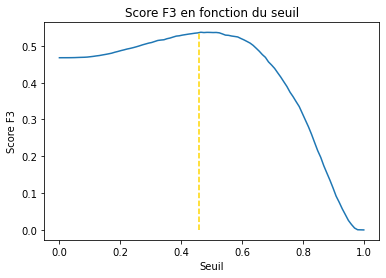

Matrice de confusion
--------------------

[[30726 25808]
 [  973  3996]]


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


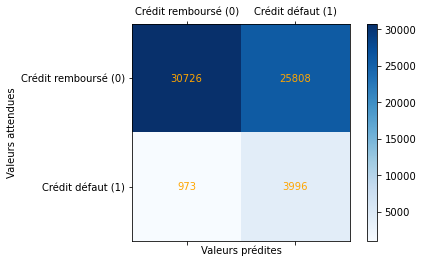


Rapport de classification
-------------------------

              precision    recall  f1-score   support

         0.0       0.97      0.54      0.70     56534
         1.0       0.13      0.80      0.23      4969

    accuracy                           0.56     61503
   macro avg       0.55      0.67      0.46     61503
weighted avg       0.90      0.56      0.66     61503


ROC AUC
-------

Score ROC AUC : 0.7489867361246051



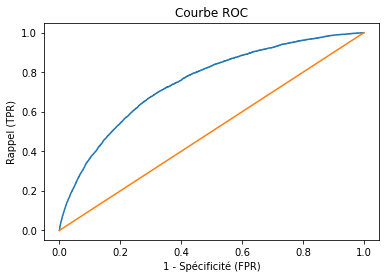

In [610]:
model_report(log_E, X_test_E, y_test_E)

#### Statistiques

In [269]:
grid_log_S = grid_log.fit(X_train_S, y_train_S)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

In [270]:
grid_log_S.best_params_

{'C': 0.1}

In [271]:
grid_log_S.best_score_

0.7011834684322723

In [272]:
log_S = grid_log_S.best_estimator_

In [312]:
#save_model(log_S, 'log_S', features=statistics.drop('TARGET', axis=1).columns)
log_S, features = restore_model('log_S')

F3-Score
--------

F3 au seuil initial de 0.5 : 0.5590962917625771
Optimisation du seuil : 0.49
F3 pour un seuil de 0.49 : 0.5594424091732684



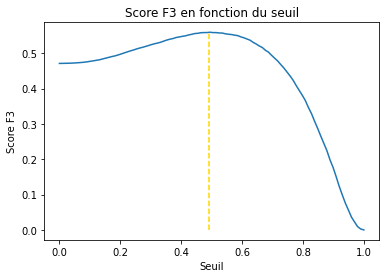

Matrice de confusion
--------------------

[[30803 25667]
 [  830  4202]]


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


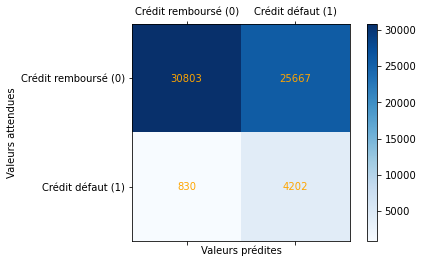


Rapport de classification
-------------------------

              precision    recall  f1-score   support

         0.0       0.97      0.55      0.70     56470
         1.0       0.14      0.84      0.24      5032

    accuracy                           0.57     61502
   macro avg       0.56      0.69      0.47     61502
weighted avg       0.91      0.57      0.66     61502


ROC AUC
-------

Score ROC AUC : 0.7712331568487623



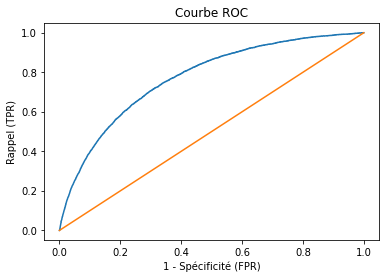

In [520]:
model_report(log_S, X_test_S, y_test_S)

#### Automatisé

In [279]:
grid_log_A = grid_log.fit(X_train_A, y_train_A)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

In [280]:
grid_log_A.best_params_

{'C': 0.001}

In [281]:
grid_log_A.best_score_

0.6896994571826531

In [284]:
log_A = grid_log_A.best_estimator_

In [314]:
#save_model(log_A, 'log_A', features=automated.drop('TARGET', axis=1).columns)
log_A, features = restore_model('log_A')

F3-Score
--------

F3 au seuil initial de 0.5 : 0.54084092126406
Optimisation du seuil : 0.48
F3 pour un seuil de 0.48 : 0.5427780474684789



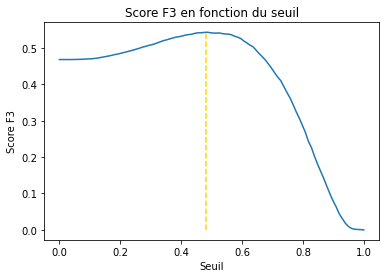

Matrice de confusion
--------------------

[[30614 25920]
 [  930  4039]]


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


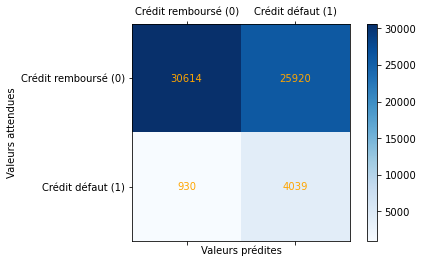


Rapport de classification
-------------------------

              precision    recall  f1-score   support

         0.0       0.97      0.54      0.70     56534
         1.0       0.13      0.81      0.23      4969

    accuracy                           0.56     61503
   macro avg       0.55      0.68      0.46     61503
weighted avg       0.90      0.56      0.66     61503


ROC AUC
-------

Score ROC AUC : 0.7560100913063263



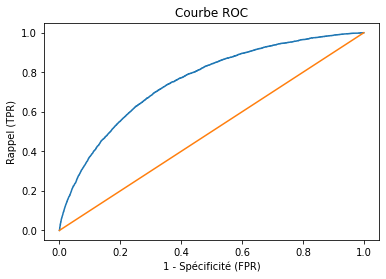

In [521]:
model_report(log_A, X_test_A, y_test_A)

[*(Retour sommaire)*](#ch0)

## <div id="ch4_3" style="color: orange;">4.3 RandomForestClassifier</div>

In [291]:
forest = RandomForestClassifier(random_state=11)
params = {
    'n_estimators': (50, 100, 150, 200),
    'criterion': ('gini', 'entropy'),
    'max_features': ('sqrt', 'log2')
}
grid_forest = GridSearchCV(estimator=forest, param_grid=params, scoring=f3, cv=strat)

#### Encodé

In [292]:
grid_forest_E = grid_forest.fit(X_train_E, y_train_E)

In [293]:
grid_forest_E.best_params_

{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 200}

In [294]:
grid_forest_E.best_score_

0.6650726735563499

In [295]:
forest_E = grid_forest_E.best_estimator_

In [312]:
save_model(forest_E, 'forest_E', features=encoded.drop('TARGET', axis=1).columns)
#forest_E, features = restore_model('forest_E')

F3-Score
--------

F3 au seuil initial de 0.5 : 0.5019788510296209
Optimisation du seuil : 0.43
F3 pour un seuil de 0.43 : 0.5345193839617631



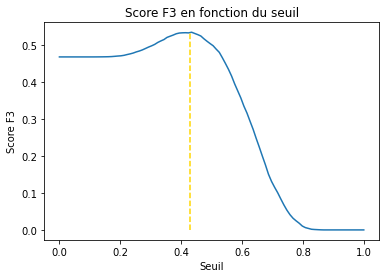

Matrice de confusion
--------------------

[[39818 16716]
 [ 1722  3247]]


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


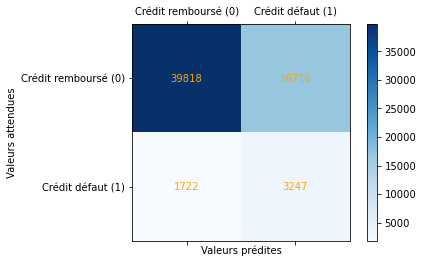


Rapport de classification
-------------------------

              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     56534
         1.0       0.16      0.65      0.26      4969

    accuracy                           0.70     61503
   macro avg       0.56      0.68      0.54     61503
weighted avg       0.89      0.70      0.77     61503


ROC AUC
-------

Score ROC AUC : 0.7416617852207014



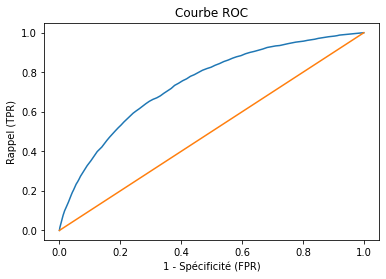

In [522]:
model_report(forest_E, X_test_E, y_test_E)

#### Statistiques

In [317]:
grid_forest_S = grid_forest.fit(X_train_S, y_train_S)

In [318]:
grid_forest_S.best_params_

{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 200}

In [319]:
grid_forest_S.best_score_

0.6815018208039636

In [320]:
forest_S = grid_forest_S.best_estimator_

In [321]:
save_model(forest_S, 'forest_S', features=statistics.drop('TARGET', axis=1).columns)
#forest_S, features = restore_model('forest_S')

F3-Score
--------

F3 au seuil initial de 0.5 : 0.5453010621275309
Optimisation du seuil : 0.5
F3 pour un seuil de 0.5 : 0.5450741775413621



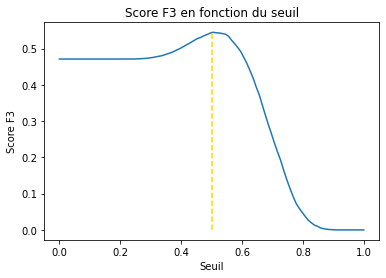

Matrice de confusion
--------------------

[[26717 29753]
 [  704  4328]]


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


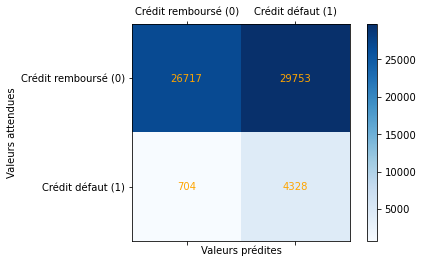


Rapport de classification
-------------------------

              precision    recall  f1-score   support

         0.0       0.97      0.47      0.64     56470
         1.0       0.13      0.86      0.22      5032

    accuracy                           0.50     61502
   macro avg       0.55      0.67      0.43     61502
weighted avg       0.90      0.50      0.60     61502


ROC AUC
-------

Score ROC AUC : 0.7514427919857273



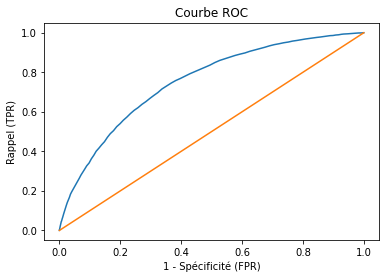

In [523]:
model_report(forest_S, X_test_S, y_test_S)

#### Automatisé

In [323]:
grid_forest_A = grid_forest.fit(X_train_A, y_train_A)

In [324]:
grid_forest_A.best_params_

{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 200}

In [325]:
grid_forest_A.best_score_

0.6733803128334722

In [326]:
forest_A = grid_forest_A.best_estimator_

In [327]:
save_model(forest_A, 'forest_A', features=automated.drop('TARGET', axis=1).columns)
#forest_A, features = restore_model('forest_A')

F3-Score
--------

F3 au seuil initial de 0.5 : 0.5338476854156297
Optimisation du seuil : 0.48
F3 pour un seuil de 0.48 : 0.5379885523048115



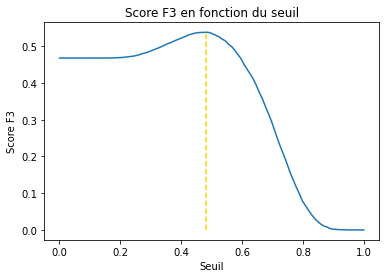

Matrice de confusion
--------------------

[[32792 23742]
 [ 1108  3861]]


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


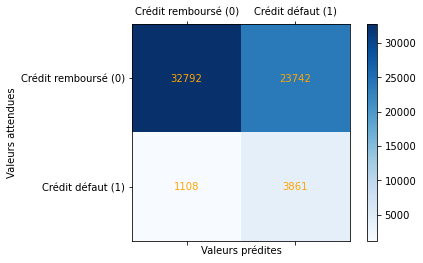


Rapport de classification
-------------------------

              precision    recall  f1-score   support

         0.0       0.97      0.58      0.73     56534
         1.0       0.14      0.78      0.24      4969

    accuracy                           0.60     61503
   macro avg       0.55      0.68      0.48     61503
weighted avg       0.90      0.60      0.69     61503


ROC AUC
-------

Score ROC AUC : 0.7473057458311079



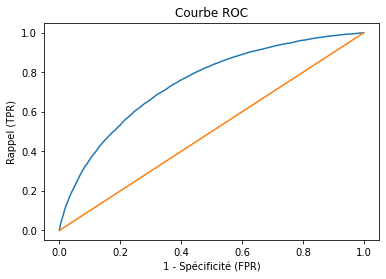

In [524]:
model_report(forest_A, X_test_A, y_test_A)

[*(Retour sommaire)*](#ch0)

## <div id="ch4_4" style="color: orange;">4.4 LGBMClassifier</div>

In [329]:
lgbm = LGBMClassifier(random_state=11)
params = {
    'boosting_type': ('gdbt', 'dart', 'goss'),
    'n_estimators': (50, 100, 150, 200),
    'learning_rate': (0.1, 0.3, 0.5, 0.7, 0.9)
}
grid_lgbm = GridSearchCV(estimator=lgbm, param_grid=params, scoring=f3, cv=strat)

#### Encodé

In [330]:
grid_lgbm_E = grid_lgbm.fit(X_train_E, y_train_E)


100 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\lightgbm\sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
  File "C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\lightgbm\engine.py", line 

In [331]:
grid_lgbm_E.best_params_

{'boosting_type': 'dart', 'learning_rate': 0.3, 'n_estimators': 200}

In [332]:
grid_lgbm_E.best_score_

0.6815709054895362

In [333]:
lgbm_E = grid_lgbm_E.best_estimator_

In [334]:
save_model(lgbm_E, 'lgbm_E', features=encoded.drop('TARGET', axis=1).columns)
#lgbm_E, features = restore_model('lgbm_E')

F3-Score
--------

F3 au seuil initial de 0.5 : 0.5066390290795482
Optimisation du seuil : 0.37
F3 pour un seuil de 0.37 : 0.5294372184183063



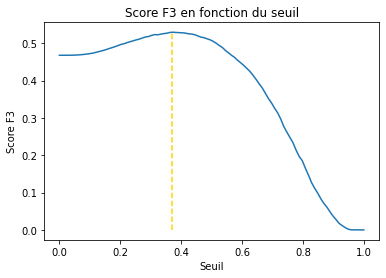

Matrice de confusion
--------------------

[[38052 18482]
 [ 1596  3373]]


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


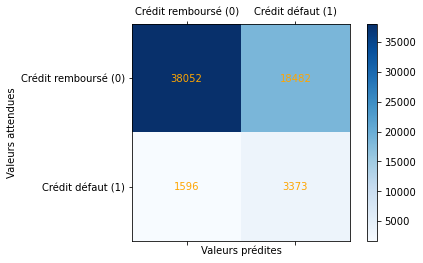


Rapport de classification
-------------------------

              precision    recall  f1-score   support

         0.0       0.96      0.67      0.79     56534
         1.0       0.15      0.68      0.25      4969

    accuracy                           0.67     61503
   macro avg       0.56      0.68      0.52     61503
weighted avg       0.89      0.67      0.75     61503


ROC AUC
-------

Score ROC AUC : 0.7374011972186306



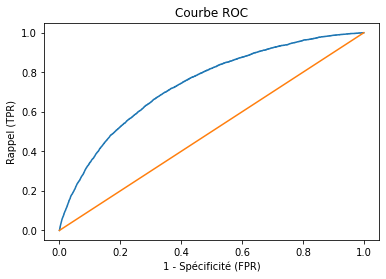

In [525]:
model_report(lgbm_E, X_test_E, y_test_E)

#### Statistiques

In [336]:
grid_lgbm_S = grid_lgbm.fit(X_train_S, y_train_S)


100 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\lightgbm\sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
  File "C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\lightgbm\engine.py", line 

In [337]:
grid_lgbm_S.best_params_

{'boosting_type': 'dart', 'learning_rate': 0.3, 'n_estimators': 100}

In [338]:
grid_lgbm_S.best_score_

0.7039984186803009

In [339]:
lgbm_S = grid_lgbm_S.best_estimator_

In [340]:
save_model(lgbm_S, 'lgbm_S', features=statistics.drop('TARGET', axis=1).columns)
#lgbm_S, features = restore_model('lgbm_S')

F3-Score
--------

F3 au seuil initial de 0.5 : 0.5494163617810299
Optimisation du seuil : 0.56
F3 pour un seuil de 0.56 : 0.5550057615400258



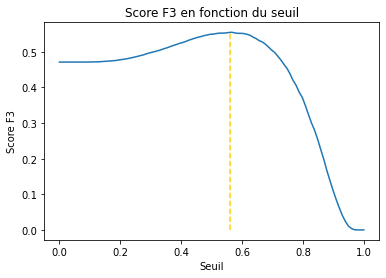

Matrice de confusion
--------------------

[[25815 30655]
 [  617  4415]]


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


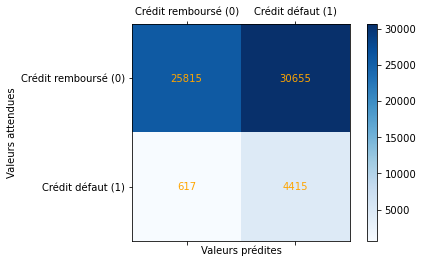


Rapport de classification
-------------------------

              precision    recall  f1-score   support

         0.0       0.98      0.46      0.62     56470
         1.0       0.13      0.88      0.22      5032

    accuracy                           0.49     61502
   macro avg       0.55      0.67      0.42     61502
weighted avg       0.91      0.49      0.59     61502


ROC AUC
-------

Score ROC AUC : 0.7668514952154626



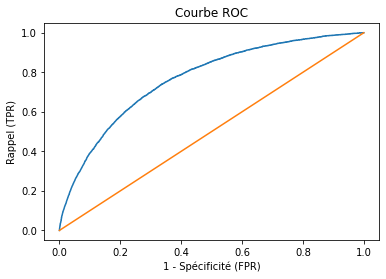

In [526]:
model_report(lgbm_S, X_test_S, y_test_S)

#### Automatisé

In [342]:
grid_lgbm_A = grid_lgbm.fit(X_train_A, y_train_A)


100 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\lightgbm\sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
  File "C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "C:\Users\aledo\anaconda3\envs\p4\lib\site-packages\lightgbm\engine.py", line 

In [343]:
grid_lgbm_A.best_params_

{'boosting_type': 'dart', 'learning_rate': 0.1, 'n_estimators': 200}

In [344]:
grid_lgbm_A.best_score_

0.691202971393241

In [345]:
lgbm_A = grid_lgbm_A.best_estimator_

In [346]:
save_model(lgbm_A, 'lgbm_A', features=automated.drop('TARGET', axis=1).columns)
#lgbm_A, features = restore_model('lgbm_A')

F3-Score
--------

F3 au seuil initial de 0.5 : 0.5421846812200204
Optimisation du seuil : 0.46
F3 pour un seuil de 0.46 : 0.5455655382002044



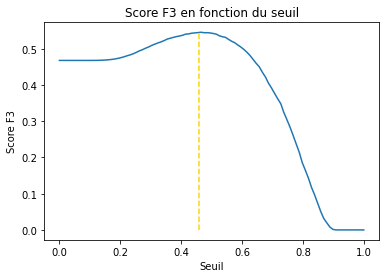

Matrice de confusion
--------------------

[[33625 22909]
 [ 1092  3877]]


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


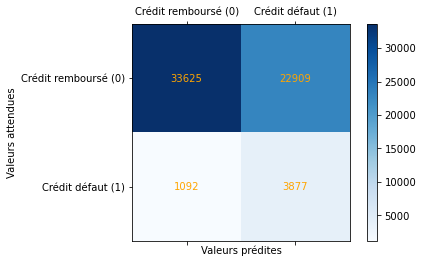


Rapport de classification
-------------------------

              precision    recall  f1-score   support

         0.0       0.97      0.59      0.74     56534
         1.0       0.14      0.78      0.24      4969

    accuracy                           0.61     61503
   macro avg       0.56      0.69      0.49     61503
weighted avg       0.90      0.61      0.70     61503


ROC AUC
-------

Score ROC AUC : 0.7579605184079596



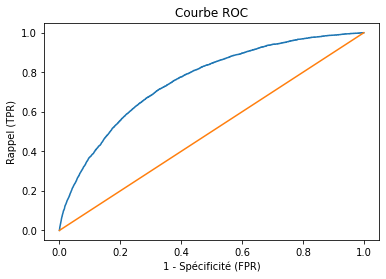

In [527]:
model_report(lgbm_A, X_test_A, y_test_A)

[*(Retour sommaire)*](#ch0)

## <div id="ch4_5" style="color: orange;">4.5 XGBClassifier</div>

In [348]:
xgb = XGBClassifier(random_state=11, use_label_encoder=False)
params = {
    'n_estimators': (50, 100, 150, 200, 250, 300),
    'learning_rate': (0.1, 0.3, 0.5, 0.7, 0.9),
    'eval_metric': ['logloss']
}
grid_xgb = GridSearchCV(estimator=xgb, param_grid=params, scoring=f3, cv=strat)

#### Encodé

In [350]:
grid_xgb_E = grid_xgb.fit(X_train_E, y_train_E)

In [351]:
grid_xgb_E.best_params_

{'eval_metric': 'logloss', 'learning_rate': 0.1, 'n_estimators': 150}

In [352]:
grid_xgb_E.best_score_

0.6824488923910709

In [353]:
xgb_E = grid_xgb_E.best_estimator_

In [354]:
save_model(xgb_E, 'xgb_E', features=encoded.drop('TARGET', axis=1).columns)
#xgb_E, features = restore_model('xgb_E')

F3-Score
--------

F3 au seuil initial de 0.5 : 0.505282147716675
Optimisation du seuil : 0.37
F3 pour un seuil de 0.37 : 0.5315337615133079



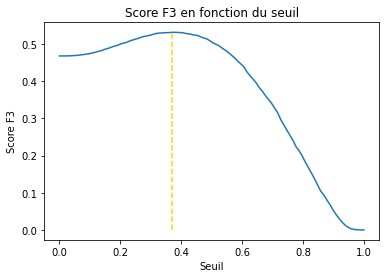

Matrice de confusion
--------------------

[[39151 17383]
 [ 1664  3305]]


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


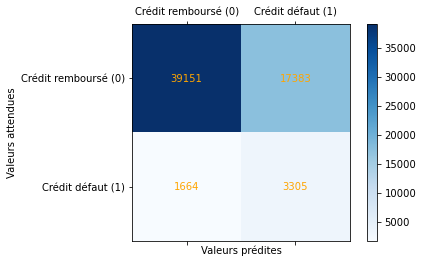


Rapport de classification
-------------------------

              precision    recall  f1-score   support

         0.0       0.96      0.69      0.80     56534
         1.0       0.16      0.67      0.26      4969

    accuracy                           0.69     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.89      0.69      0.76     61503


ROC AUC
-------

Score ROC AUC : 0.7405139640205899



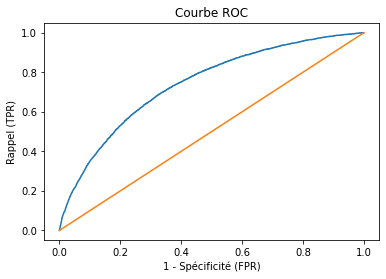

In [528]:
model_report(xgb_E, X_test_E, y_test_E)

#### Statistiques

In [356]:
grid_xgb_S = grid_xgb.fit(X_train_S, y_train_S)

In [357]:
grid_xgb_S.best_params_

{'eval_metric': 'logloss', 'learning_rate': 0.1, 'n_estimators': 300}

In [358]:
grid_xgb_S.best_score_

0.7032334655499612

In [359]:
xgb_S = grid_xgb_S.best_estimator_

In [360]:
save_model(xgb_S, 'xgb_S', features=statistics.drop('TARGET', axis=1).columns)
#xgb_S, features = restore_model('xgb_S')

F3-Score
--------

F3 au seuil initial de 0.5 : 0.5325781677912573
Optimisation du seuil : 0.62
F3 pour un seuil de 0.62 : 0.54821735395189



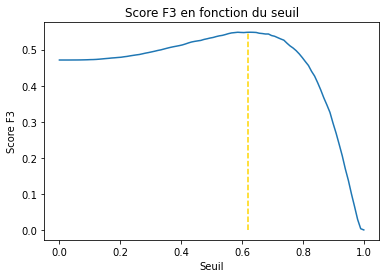

Matrice de confusion
--------------------

[[20519 35951]
 [  462  4570]]


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


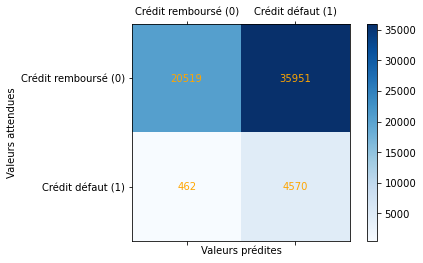


Rapport de classification
-------------------------

              precision    recall  f1-score   support

         0.0       0.98      0.36      0.53     56470
         1.0       0.11      0.91      0.20      5032

    accuracy                           0.41     61502
   macro avg       0.55      0.64      0.37     61502
weighted avg       0.91      0.41      0.50     61502


ROC AUC
-------

Score ROC AUC : 0.7610668294545861



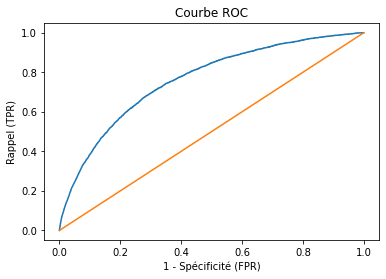

In [529]:
model_report(xgb_S, X_test_S, y_test_S)

#### Automatisé

In [362]:
grid_xgb_A = grid_xgb.fit(X_train_A, y_train_A)

In [363]:
grid_xgb_A.best_params_

{'eval_metric': 'logloss', 'learning_rate': 0.1, 'n_estimators': 200}

In [364]:
grid_xgb_A.best_score_

0.6906621795150611

In [365]:
xgb_A = grid_xgb_A.best_estimator_

In [366]:
save_model(xgb_A, 'xgb_A', features=automated.drop('TARGET', axis=1).columns)
#xgb_A, features = restore_model('xgb_A')

F3-Score
--------

F3 au seuil initial de 0.5 : 0.5376588990590613
Optimisation du seuil : 0.43
F3 pour un seuil de 0.43 : 0.543737090684243



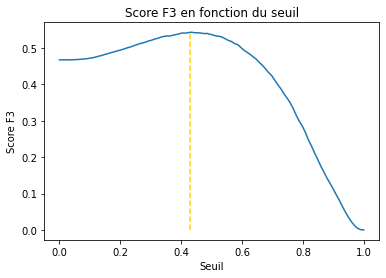

Matrice de confusion
--------------------

[[34783 21751]
 [ 1192  3777]]


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


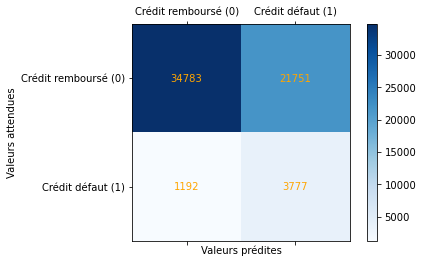


Rapport de classification
-------------------------

              precision    recall  f1-score   support

         0.0       0.97      0.62      0.75     56534
         1.0       0.15      0.76      0.25      4969

    accuracy                           0.63     61503
   macro avg       0.56      0.69      0.50     61503
weighted avg       0.90      0.63      0.71     61503


ROC AUC
-------

Score ROC AUC : 0.7541468250426853



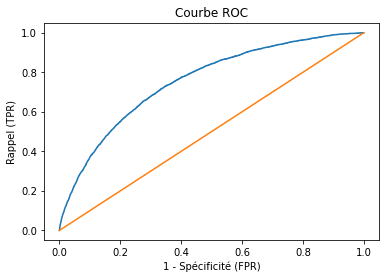

In [530]:
model_report(xgb_A, X_test_A, y_test_A)

[*(Retour sommaire)*](#ch0)

## <div id="ch4_6" style="color: orange;">4.6 Configuration retenue</div>

#### Choix du modèle

<img src="img/strategie_table_optimisee.png">

Nous utiliserons ici le model de **régression logistique** avec le jeu de données **Statistiques**.

C'est en effet cette combinaison qui a donné, au cours de tous nos tests, le meilleur score F3 (0,559) ainsi que le meilleur score AUC (0,771).

#### Importance des variables

In [559]:
model = log_S

In [563]:
shap.initjs()
#explainer = shap.TreeExplainer(model)
explainer = shap.LinearExplainer(model, masker=shap.maskers.Impute(X_train_S))
shap_values = explainer.shap_values(X_train_S)

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

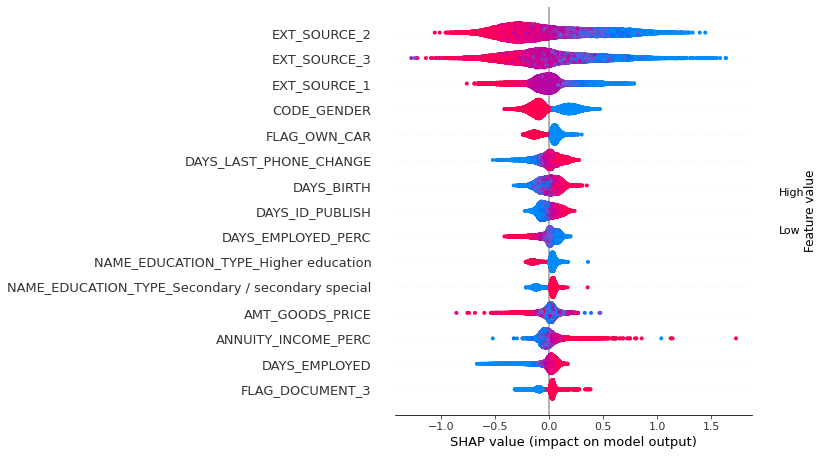

In [589]:
features = statistics.drop('TARGET', axis=1).columns
df = pd.DataFrame(data=X_train_S, columns=features)
shap.summary_plot(shap_values, df, max_display=15)

Plusieurs constats peuvent être faits en observant ce diagramme :

- Les 3 plus importantes variables dont le modèle se sert pour effectuer sa décision (`EXT_SOURCE_2`, `EXT_SOURCE_3` et `EXT_SOURCE_1`) sont des données externes "boîtes noires" : nous ne savons ni ce quelles représentent ni comment elles sont atribuées.
- Parmis les 15 variables les plus influentes (sur un total de 809), 4 sont issues du feature engineering : `DAYS_EMPLOYED_PERC`, `NAME_EDUCATION_TYPE_Higher education`, `NAME_EDUCATION_TYPE_Higher education / secondary special`, et `ANNUITY_INCOME_PERC` : c'est donc une preuve de l'importance du travail réalisé en amont et un facteur pouvant expliquer les meilleurs scores obtenus par ce jeu de données à tous les tests réalisés au chapitre 4.
- Parmis les variables les plus influentes, la plupart sont très discriminantes (âge, sexe, etc.) et non directement liées à des facteurs objectivement économiques : une attention particulière doit être portée à la sécurisation de l'obtention de ces données lors de la souscription, en particulier vis-à-vis du RGPD.

[*(Retour sommaire)*](#ch0)

# <div id="ch5" style="color: blue">5. Conclusion</div>

<div class="alert alert-block alert-info">
    
A l'aide du jeu de données "statistics" que nous avons obtenu par feature engineering et du modèle de régression logistique développé dessus dont les hyperparamètres ont été optimisés par recherche croisée, nous sommes à présent capables de prédire chaque instance de dossier de prêt qui nous est soumise.
    
Ci-dessous une simulation tirée du jeu de données d'entraînement : pour changer de ligne à simuler il suffit de modifier la variable `idx` et de relancer toutes les cellules suivantes.
    
Dans un notebook séparé appelé <b>P4_Application.ipynb</b> un exemple d'application *standalone* a été développé afin que les conseillés clientelle puissent obtenir une réponse et un commentaire immédiat sur chaque demande de prêt.
    
</div>

In [52]:
#Source : https://github.com/slundberg/shap/issues/1420
class ShapObject:
    def __init__(self, base_values, data, values, feature_names):
        self.base_values = base_values # Single value
        self.data = data # Raw feature values for 1 row of data
        self.values = values # SHAP values for the same row of data
        self.feature_names = feature_names # Column names

In [577]:
def get_shap_object(idx):
    shap_object = ShapObject(base_values=explainer.expected_value,
                             values=explainer.shap_values(X_test_S)[idx,:],
                             feature_names=features,
                             data=X_test_S[idx,:])
    return shap_object

In [580]:
idx = 2

In [581]:
prediction = int(model.predict(X_test_S[[idx]])[0])
reel = int(y_test_S.iloc[idx])
classes = {0: 'Crédit remboursé', 1: 'Crédit défaut'}
print(f"Classe réelle : {reel} -> {classes[reel]}")
print(f"Classe prédite : {prediction} -> {classes[prediction]}")

Classe réelle : 0 -> Crédit remboursé
Classe prédite : 1 -> Crédit défaut


Probabilités prédites par le modèle pour chaque classe :
------------------------------------------------------


FixedFormatter should only be used together with FixedLocator


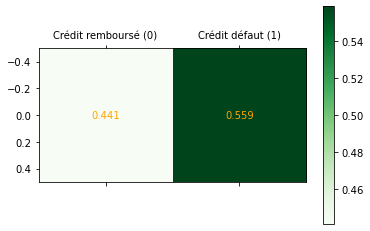

In [582]:
print(f"Probabilités prédites par le modèle pour chaque classe :")
print('------------------------------------------------------')
proba = model.predict_proba(X_test_S[[idx]])
labels = ['Crédit remboursé (0)', 'Crédit défaut (1)']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(proba, cmap=plt.cm.Greens)
for i in range(0, 2):
    text = ax.text(i, 0, round(proba[0][i], 3), ha="center", va="center", color="orange")
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
plt.show()

In [584]:
print(f"Influence des variables sur la décision -> Diagramme de forces :")
print('--------------------------------------------------------------')
shap.force_plot(
    explainer.expected_value,
    explainer.shap_values(X_test_S)[idx,:],
    feature_names=features,
    out_names='Sortie')

Influence des variables sur la décision -> Diagramme de forces :
--------------------------------------------------------------


Influence des variables sur la décision -> Diagramme en cascade :
---------------------------------------------------------------


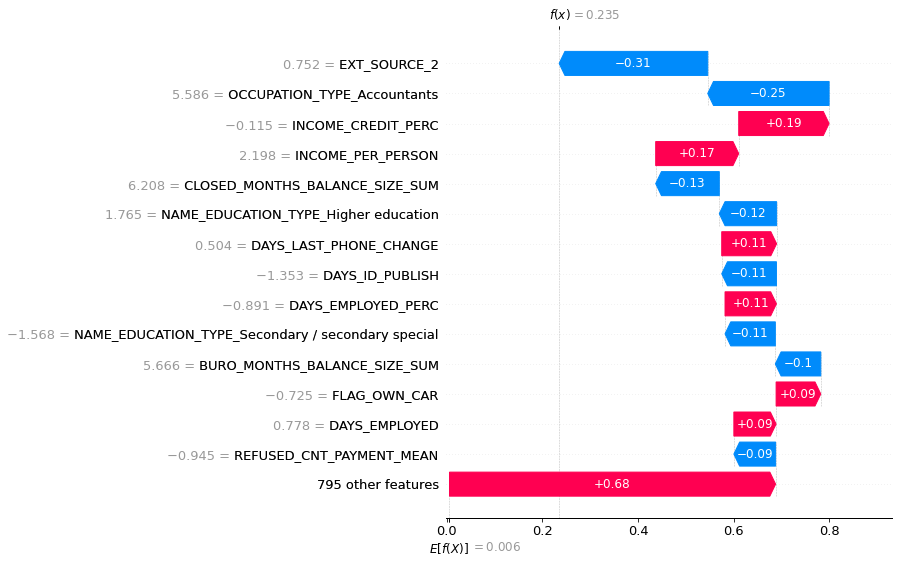

In [585]:
print(f"Influence des variables sur la décision -> Diagramme en cascade :")
print('---------------------------------------------------------------')
shap.waterfall_plot(get_shap_object(idx), max_display=15)

Influence des variables sur la décision -> Diagramme de décision :
----------------------------------------------------------------


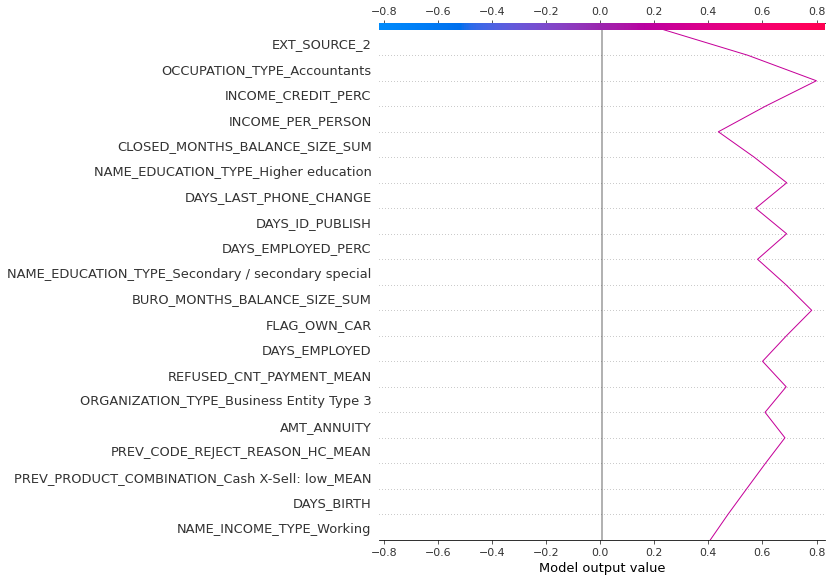

In [586]:
print(f"Influence des variables sur la décision -> Diagramme de décision :")
print('----------------------------------------------------------------')
shap.decision_plot(explainer.expected_value,
                   explainer.shap_values(X_test_S)[idx,:],
                   feature_names=features.to_list())

[*(Retour sommaire)*](#ch0)